# Libraries and Packages

In [ ]:
pip install mplsoccer

In [ ]:
pip install cmasher

In [ ]:
pip install Scraperfc

In [ ]:
pip install highlight_text

In [ ]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch
from matplotlib.font_manager import FontProperties
from mplsoccer import Pitch, FontManager, Sbopen
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import cmasher as cmr
from mplsoccer import VerticalPitch, Sbopen
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from mplsoccer import VerticalPitch, FontManager, Sbopen, add_image
from mplsoccer.pitch import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import ScraperFC as sfc
from highlight_text import ax_text
from highlight_text import fig_text, HighlightText
from sklearn.cluster import KMeans
import warnings

In [ ]:
# Print the modified DataFrame
pd.set_option('display.max_columns', None)

black = '#171819'
white = '#fffdd0'
red = '#ff4081'
green = '#69f900'
blue = '#00b8d4'

# EventDataScraping

---



In [ ]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

match_html_path = '/content/Lazio 0-1 AC Milan - Serie A 2023_2024 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

df.to_csv('EventData.csv')
df = pd.read_csv('/content/EventData.csv')
dfp.to_csv('PlayerData.csv')
dfp = pd.read_csv('/content/PlayerData.csv')

In [ ]:
# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT = dfxT[~dfxT['qualifiers'].str.contains('Corner') & ~dfxT['qualifiers'].str.contains('ThrowIn')]
dfxT = dfxT[(dfxT['type']=='Pass') & (dfxT['outcomeType']=='Successful')]

xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
                   'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
                   'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='Unnamed: 0', how='left')

# Reshaping the data from 100x100 to 105x68
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68
df['goalMouthZ'] = df['goalMouthZ']*0.061

columns_to_drop = ['Unnamed: 0','height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
                   'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)
df = df.merge(dfp, on='playerId', how='left')

# Calculating passing distance, to find out progressive pass
df['pro'] = np.where((df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['x'] > 42),
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2),
                            0)
# converting the x values to y values and vice versa
df['x'], df['y'] = df['y'].values, df['x'].values
df['endX'], df['endY'] = df['endY'].values, df['endX'].values

# print(df)

In [ ]:
hteamID = list(teams_dict.keys())[0]  # selected home team
ateamID = list(teams_dict.keys())[1]  # selected away team
hteamName= teams_dict[hteamID]
ateamName= teams_dict[ateamID]
hcol= blue
acol= red

In [ ]:
homedf = df[(df['teamId']==hteamID)]
awaydf = df[(df['teamId']==ateamID)]
hxT = homedf['xT'].sum().round(2)
axT = awaydf['xT'].sum().round(2)
print(hxT)
print(axT)

In [ ]:
url = 'https://www.sofascore.com/athletic-club-barcelona/rgbsAgb#id:11368732'
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'} # you'll be blocked if you don't use some type of user agent
)

soup = BeautifulSoup(response.text, 'html.parser')
soup.select('g[cursor="pointer"]')

# These are the headers we need to access the API
headers = {
    'authority': 'api.sofascore.com',
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'dnt': '1',
    'if-none-match': 'W/"4bebed6144"',
    'origin': 'https://www.sofascore.com',
    'referer': 'https://www.sofascore.com/',
    'sec-ch-ua': '"Not.A/Brand";v="8", "Chromium";v="114"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
}

# you'll need to change the url to match the one you copied. As you can see they have some sort of match id to identify the game --> 10385636
response = requests.get('https://api.sofascore.com/api/v1/event/11406829/shotmap', headers=headers)

In [ ]:
response

In [ ]:
# # The way to fix this is to add the 'If-Modified-Since' header to the request
# # You can change this dynamically or just hardcode and change it every time you run the script
# headers['If-Modified-Since'] = 'Sat, 02 Mar 2024 00:00:00 GMT'
# from datetime import datetime
# current_date_time = datetime.utcnow()
# headers['If-Modified-Since'] = f'{current_date_time}'

In [ ]:
# # Now we get a 200 response
# response = requests.get('https://api.sofascore.com/api/v1/event/11352521/shotmap', headers=headers)
# response

In [ ]:
shots = response.json()

# Extracting relevant information
data = []
for entry in shots['shotmap']:
    player_info = entry['player']
    shot_start = entry['playerCoordinates']
    shot_end = entry['goalMouthCoordinates']
    goalType = entry.get('goalType', '0')
    xgot = entry.get('xgot', '0')
    xg = entry.get('xg', '0')
    entry_data = {
        # 'name': player_info['name'],
        'shortName': player_info['shortName'],
        'shotType': entry['shotType'],
        'goalType': goalType,
        'situation': entry['situation'],
        'xg': xg,
        'xgot': xgot
    }
    data.append(entry_data)

# Creating DataFrame
df_shots = pd.DataFrame(data)
df_shots['xgot'] = pd.to_numeric(df_shots['xgot'], errors='coerce')
df_shots['xg'] = pd.to_numeric(df_shots['xg'], errors='coerce')
df_shots['xg'] = df_shots['xg'].round(5)
df_shots['xgot'] = df_shots['xgot'].round(5)
df_shots = df_shots[::-1]
df_shots = df_shots.reset_index(drop=True)

mask = (df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')
temp_shot = df[mask]
temp_shot.reset_index(drop=True, inplace=True)
ShotsData = pd.concat([temp_shot, df_shots], axis=1)

columns_to_drop = ['Unnamed: 0','id','expandedMinute','qualifiers','satisfiedEventsTypes','isTouch','playerId','isShot',
                   'isGoal', 'x1_bin_xT','y1_bin_xT', 'x2_bin_xT', 'y2_bin_xT', 'start_zone_value_xT',
                   'end_zone_value_xT', 'xT', 'pro', 'type', 'outcomeType', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId']
ShotsData.drop(columns=columns_to_drop, inplace=True)

print(ShotsData)

In [ ]:
# sofascore = sfc.Sofascore()

# match_momentum = sofascore.match_momentum('https://www.sofascore.com/bayer-04-leverkusen-fc-bayern-munchen/xdbsGdb#11396298')

In [ ]:
# Use this codes to separate the penalty shootout data from the main dataframe
# ShotsDataMain = ShotsData
# ShootoutData = ShotsData[ShotsData['situation'] == 'shootout']
# ShotsData = ShotsData[ShotsData['situation'] != 'shootout']

In [ ]:
hteam_shots = ShotsData[ShotsData['teamId'] == hteamID]
ateam_shots = ShotsData[ShotsData['teamId'] == ateamID]

htotal_shots = len(hteam_shots)
atotal_shots = len(ateam_shots)
htypes_count = hteam_shots['shotType'].value_counts()
atypes_count = ateam_shots['shotType'].value_counts()
hgoal_count = htypes_count.get('goal', 0)
agoal_count = atypes_count.get('goal', 0)
# Use this to add the goal counts manually if there is any own goal
# hgoal_count = 2
# agoal_count = 6

In [ ]:
file_header = 'lutmnc'

In [ ]:
df.to_csv(f'{file_header}.csv')
from google.colab import files
files.download(f'{file_header}.csv')

ShotsData.to_csv(f'{file_header}Shots.csv')
from google.colab import files
files.download(f'{file_header}Shots.csv')

# Team Performance Visualization

---



Pass Network

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

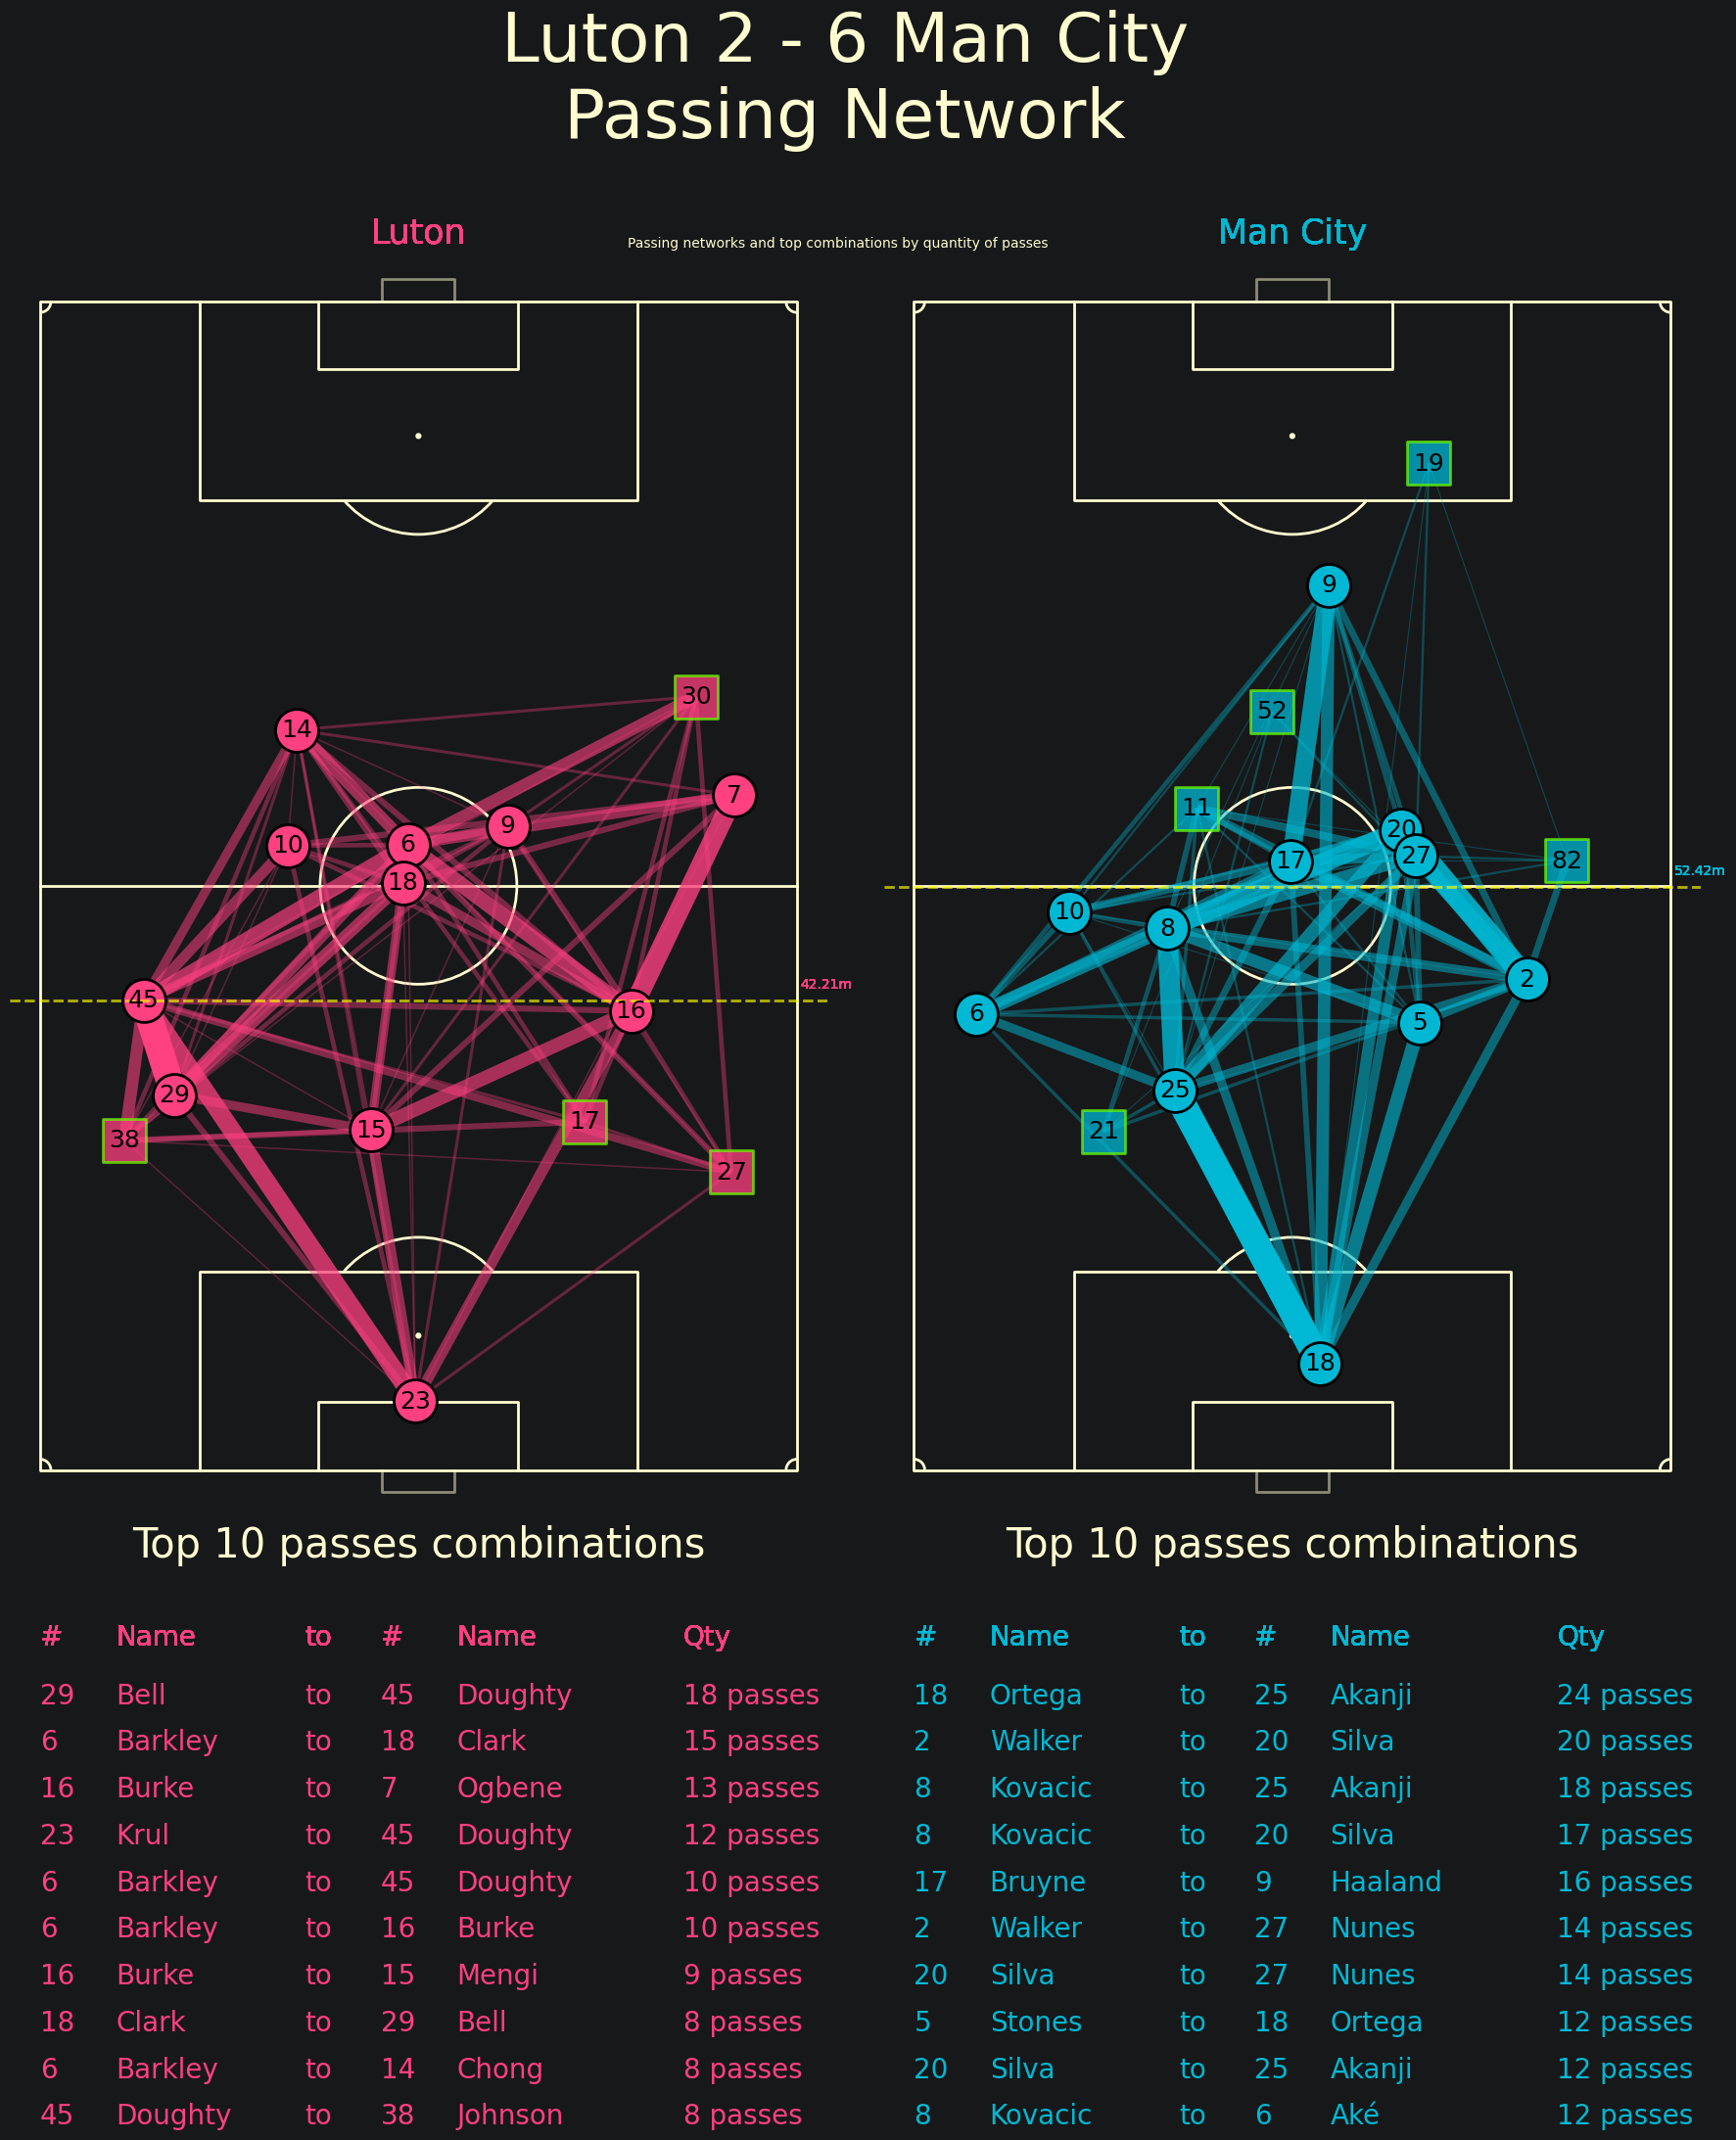

In [ ]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df["receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

passes_df = get_passes_df(events_dict)

def get_passes_between_df(team_id, passes_df, players_df):
    passes_df = passes_df[passes_df["teamId"] == team_id]
    df = pd.DataFrame(events_dict)
    dfteam = df[df['teamId'] == team_id]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, team_id, flipped=False):
    MAX_LINE_WIDTH = 20
    MAX_MARKER_SIZE = 1500
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
    MIN_TRANSPARENCY = 0.25
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = VerticalPitch(pitch_type='opta', goal_type='box', goal_alpha=.5, corner_arcs=True, pitch_color=black, line_color=white, linewidth=2)
    pitch.draw(ax=ax)

    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color=color, zorder=1, ax=ax)

    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='o', color=col, edgecolor='black', linewidth=2, alpha=1, ax=ax)
      else:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='s', color=col, edgecolor=green, linewidth=2, alpha=0.75, ax=ax)

    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c='black', ha='center', va='center', size=18, ax=ax)

    ax.text(50, -7.5, "Top 10 passes combinations", fontsize=30, color=white, ha='center')
    df_sorted = passes_between_df.sort_values(by='pass_count', ascending=False)
    top_10_rows = df_sorted.head(10)

    yco = -20
    for index, row in top_10_rows.iterrows():
      text_to_display = f"{row['shirtNo']}"
      ax.text(100, yco, text_to_display, fontsize=20, color=col, ha='left')
      yco -= 4
    # Name
    yco = -20
    for index, row in top_10_rows.iterrows():
      text_to_display = f"{row['name'].split()[-1]}"
      ax.text(90, yco, text_to_display, fontsize=20, color=col, ha='left')
      yco -= 4
    # to
    yco = -20
    for index, row in top_10_rows.iterrows():
      text_to_display = "to"
      ax.text(65, yco, text_to_display, fontsize=20, color=col, ha='left')
      yco -= 4
    # _end
    yco = -20
    for index, row in top_10_rows.iterrows():
      text_to_display = f"{row['shirtNo_end']}"
      ax.text(55, yco, text_to_display, fontsize=20, color=col, ha='left')
      yco -= 4
    # Name_end
    yco = -20
    for index, row in top_10_rows.iterrows():
      text_to_display = f"{row['name_end'].split()[-1]}"
      ax.text(45, yco, text_to_display, fontsize=20, color=col, ha='left')
      yco -= 4
    # Quantity
    yco = -20
    for index, row in top_10_rows.iterrows():
      text_to_display = f"{row['pass_count']} passes"
      ax.text(15, yco, text_to_display, fontsize=20, color=col, ha='left')
      yco -= 4
      ax.text(100, -15, "#", fontsize=20, color=col, ha='left')
      ax.text(90, -15, "Name", fontsize=20, color=col, ha='left')
      ax.text(65, -15, "to", fontsize=20, color=col, ha='left')
      ax.text(55, -15, "#", fontsize=20, color=col, ha='left')
      ax.text(45, -15, "Name", fontsize=20, color=col, ha='left')
      ax.text(15, -15, "Qty", fontsize=20, color=col, ha='left')
      ax.text(50, 105, teams_dict[team_id], color=col, fontsize=25, ha='center')
      avgph = average_locs_and_count_df['pass_avg_x'].median().round(2)
      avgph_show = (avgph*1.05).round(2)
      ax.axhline(y=avgph, color='yellow', linestyle='--', alpha=0.1, linewidth=2)
      ax.text(-0.5, avgph+1, f"{avgph_show}m", fontsize=10, color=col, ha='left')

    return pitch

# create plot
fig, axes = plt.subplots(1, 2, figsize=(18, 32))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor(black)

main_color = white
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df, hcol, home_team_id)
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, acol, away_team_id)

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nPassing Network", color=main_color, fontsize=50, va='center', ha='center', y=0.76)
subtitle = "Passing networks and top combinations by quantity of passes"
plt.text(110, 105, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=10)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Pass_Network.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Pass_Network.png')

ShotMap(Sofascore)



Text(0.5, 0.98, 'Sassuolo 1 - 6 Napoli\nShot Map')

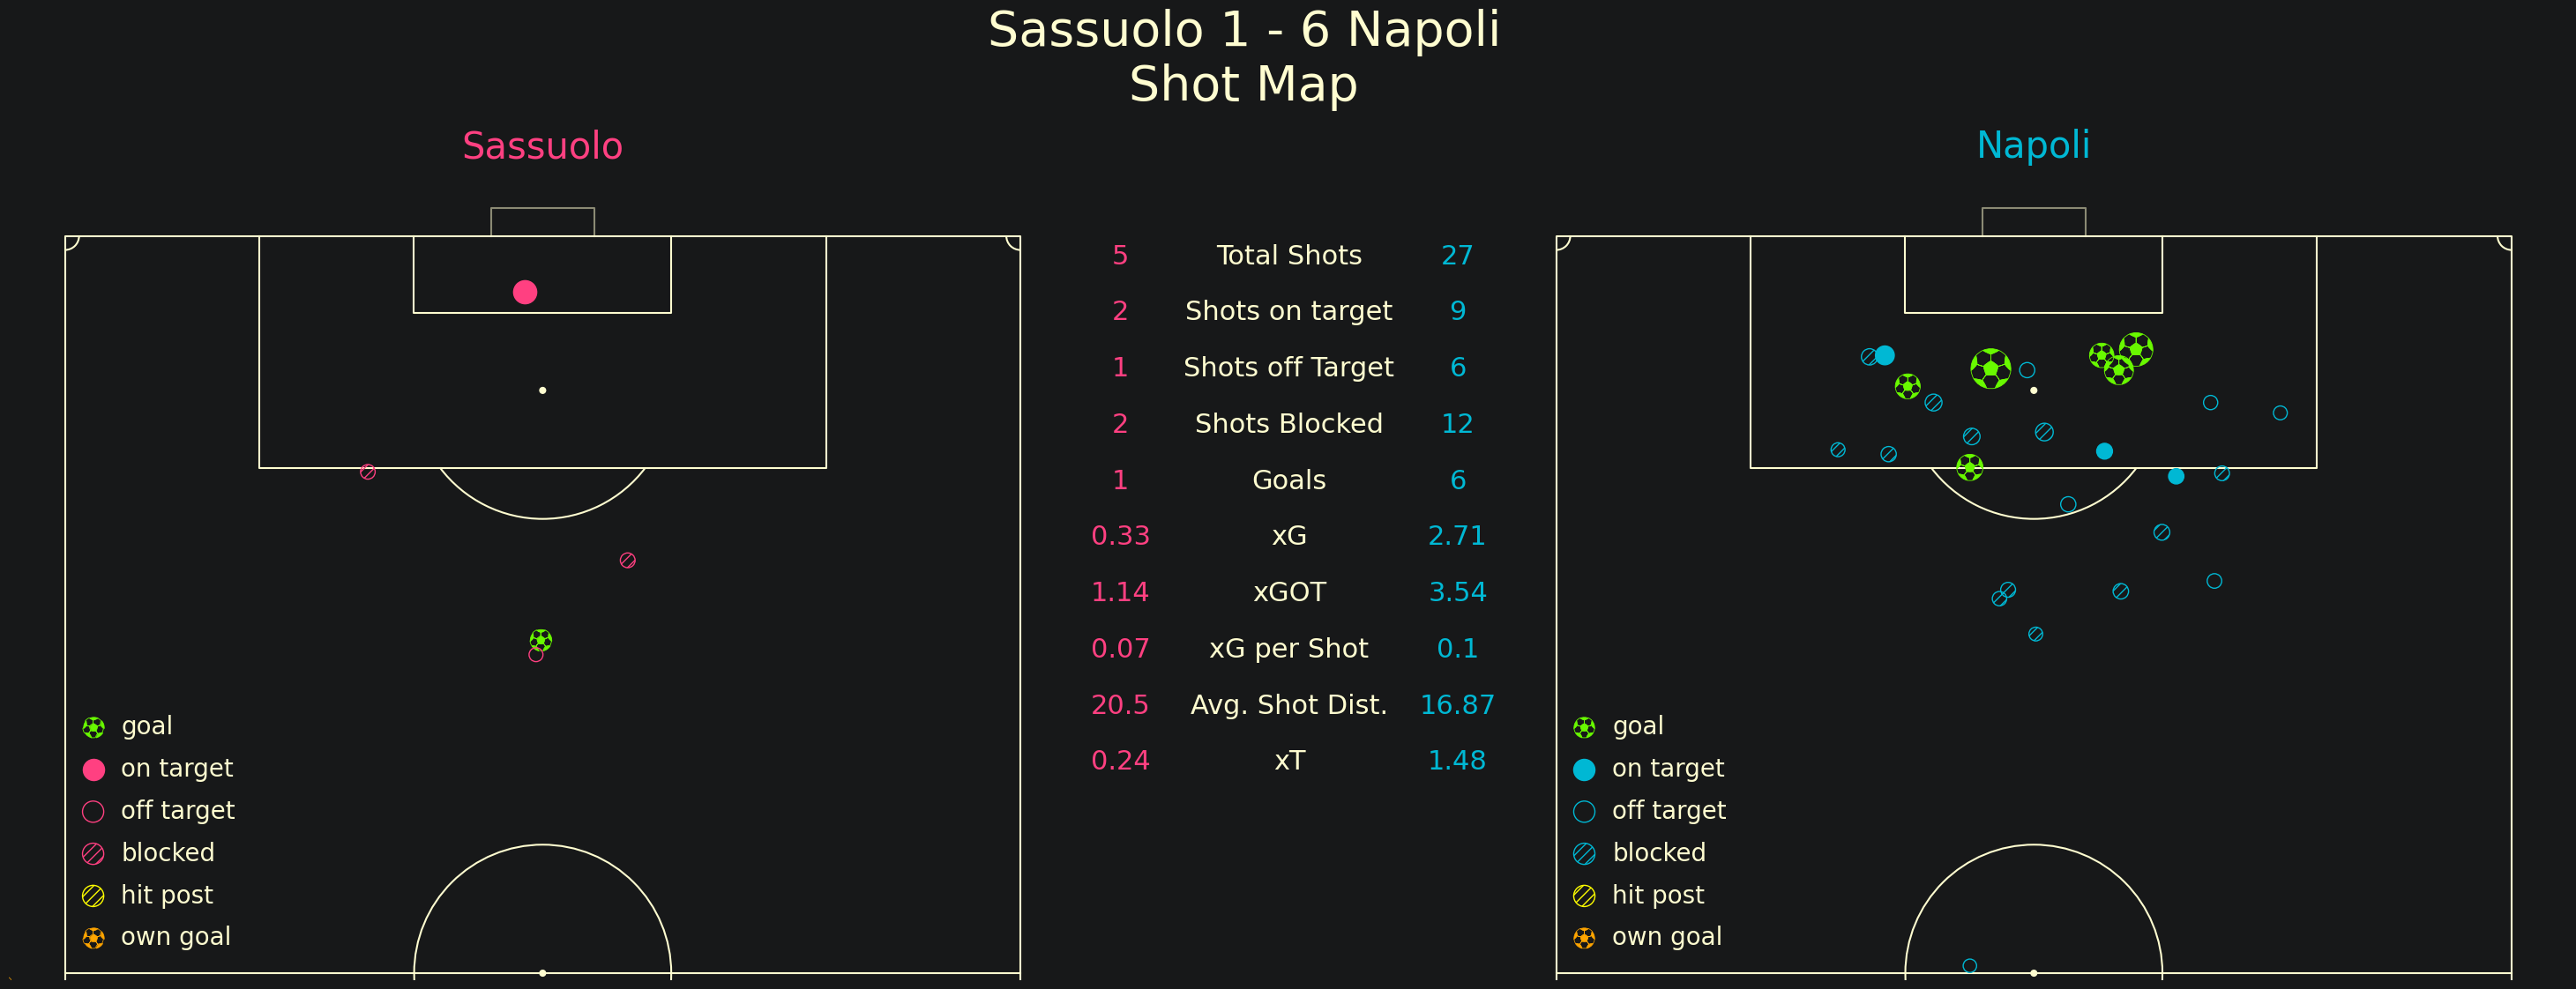

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(40, 12), facecolor=black)

def plot_shotmap(ax, teamID, teamName, col):
    # Set up the pitch
    pitch = VerticalPitch(pitch_type='uefa', goal_type='box', goal_alpha=.5, corner_arcs=True, pitch_color=black, linewidth=1.5, line_color=white, half=True)
    pitch.draw(ax=ax)
    ax.set_ylim(52, 110)

    GoalsData = ShotsData[(ShotsData['teamId'] == teamID) & (ShotsData['shotType'] == 'goal')]
    BlockData = ShotsData[(ShotsData['teamId'] == teamID) & (ShotsData['shotType'] == 'block')]
    PostData = ShotsData[(ShotsData['teamId'] == teamID) & (ShotsData['shotType'] == 'post')]
    OGData = ShotsData[(ShotsData['teamId'] != teamID) & (ShotsData['goalType'] == 'own')]
    SaveData = ShotsData[(ShotsData['teamId'] == teamID) & (ShotsData['shotType'] == 'save')]
    MissData = ShotsData[(ShotsData['teamId'] == teamID) & (ShotsData['shotType'] == 'miss')]

    sc1 = pitch.scatter(GoalsData.y, GoalsData.x, s=(GoalsData.xg * 1200) + 300, edgecolors=green, linewidths=0.6, c='None', marker='football', ax=ax)
    sc2 = pitch.scatter(BlockData.y, BlockData.x, s=(BlockData.xg * 1200) + 100, edgecolors=col, c='None', hatch='///', marker='o', ax=ax)
    sc3 = pitch.scatter(PostData.y, PostData.x, s=(PostData.xg * 1200) + 100, edgecolors='yellow', c='None', hatch='///', marker='o', ax=ax)
    sc4 = pitch.scatter(abs(OGData.y - 105), abs(OGData.x - 68), s=600, edgecolors='orange', c='None', marker='football', ax=ax)
    sc5 = pitch.scatter(SaveData.y, SaveData.x, s=(SaveData.xg * 1200) + 100, edgecolors=col, c=col, marker='o', ax=ax)
    sc6 = pitch.scatter(MissData.y, MissData.x, s=(MissData.xg * 1200) + 100, edgecolors=col, c='None', marker='o', ax=ax)

    goal_sc = pitch.scatter(70, 66, s=300, edgecolors=green, linewidths=0.6, c='None', marker='football', ax=ax)
    save_sc = pitch.scatter(70-3, 66, s=300, edgecolors=col, c=col, marker='o', ax=ax)
    miss_sc = pitch.scatter(70-6, 66, s=300, edgecolors=col, c='None', marker='o', ax=ax)
    block_sc = pitch.scatter(70-9, 66, s=300, edgecolors=col, c='None', hatch='///', marker='o', ax=ax)
    post_sc = pitch.scatter(70-12, 66, s=300, edgecolors='yellow', c='None', hatch='///', marker='o', ax=ax)
    og_sc = pitch.scatter(70-15, 66, s=300, edgecolors='orange', c='None', marker='football', ax=ax)

    goal_txt = pitch.text(70, 64, 'goal', color=white, fontsize=20, va='center', ha='left', ax=ax)
    save_txt = pitch.text(70-3, 64, 'on target', color=white, fontsize=20, va='center', ha='left', ax=ax)
    miss_txt = pitch.text(70-6, 64, 'off target', color=white, fontsize=20, va='center', ha='left', ax=ax)
    block_txt = pitch.text(70-9, 64, 'blocked', color=white, fontsize=20, va='center', ha='left', ax=ax)
    post_txt = pitch.text(70-12, 64, 'hit post', color=white, fontsize=20, va='center', ha='left', ax=ax)
    og_txt = pitch.text(70-15, 64, 'own goal', color=white, fontsize=20, va='center', ha='left', ax=ax)

    ax.set_title(teamName, color=col, fontsize=30)

plot_shotmap(axs[0], hteamID, hteamName, hcol)
plot_shotmap(axs[1], ateamID, ateamName, acol)
# Stats Calculation
hteam_shots = ShotsData[ShotsData['teamId'] == hteamID]
ateam_shots = ShotsData[ShotsData['teamId'] == ateamID]
htotal_shots = len(hteam_shots)
atotal_shots = len(ateam_shots)
htypes_count = hteam_shots['shotType'].value_counts()
atypes_count = ateam_shots['shotType'].value_counts()
hoff_target = htypes_count.get('miss', 0)
h_blocked = htypes_count.get('block', 0)
hon_target = htypes_count.get('save', 0)
# hgoal_count = htypes_count.get('goal', 0)
aoff_target = atypes_count.get('miss', 0)
a_blocked = atypes_count.get('block', 0)
aon_target = atypes_count.get('save', 0)
# agoal_count = atypes_count.get('goal', 0)
hxG = round(hteam_shots['xg'].sum(),2)
axG = round(ateam_shots['xg'].sum(),2)
hxGOT = round(hteam_shots['xgot'].sum(),2)
axGOT = round(ateam_shots['xgot'].sum(),2)
hxgpsh = round(hxG/htotal_shots, 2)
axgpsh = round(axG/atotal_shots, 2)
hon_target = hon_target + hgoal_count
aon_target = aon_target + agoal_count
homenpShots = ShotsData[(ShotsData['teamId']==hteamID) & (ShotsData['shotType']!='penalty')]
awaynpShots = ShotsData[(ShotsData['teamId']==ateamID) & (ShotsData['shotType']!='penalty')]
homeavgdist = (105-(homenpShots['y'].mean())).round(2)
awayavgdist = (105-(awaynpShots['y'].mean())).round(2)
# Add custom text side the plot for ateam
count_lines = [
    "Total Shots",
    "Shots on target",
    "Shots off Target",
    "Shots Blocked",
    "Goals",
    "xG",
    "xGOT",
    "xG per Shot",
    "Avg. Shot Dist.",
    "xT"
]
# Add custom text lines for counts side the plot
y_coordinate = 103  # Adjust the y-coordinate as needed
for line in count_lines:
    plt.text(87, y_coordinate, line, fontsize=22, color=white, ha='center')
    y_coordinate -= 4

hcount_lines = [
    f"{htotal_shots}",
    f"{hon_target}",
    f"{hoff_target}",
    f"{h_blocked}",
    f"{hgoal_count}",
    f"{hxG}",
    f"{hxGOT}",
    f"{hxgpsh}",
    f"{homeavgdist}",
    f"{hxT}"
]
# Add custom text lines for counts side the plot
y_coordinate = 103  # Adjust the y-coordinate as needed
for line in hcount_lines:
    plt.text(87+12, y_coordinate, line, fontsize=22, color=hcol, ha='center')
    y_coordinate -= 4

acount_lines = [
    f"{atotal_shots}",
    f"{aon_target}",
    f"{aoff_target}",
    f"{a_blocked}",
    f"{agoal_count}",
    f"{axG}",
    f"{axGOT}",
    f"{axgpsh}",
    f"{awayavgdist}",
    f"{axT}"
]
# Add custom text lines for counts side the plot
y_coordinate = 103  # Adjust the y-coordinate as needed
for line in acount_lines:
    plt.text(87-12, y_coordinate, line, fontsize=22, color=acol, ha='center')
    y_coordinate -= 4

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nShot Map", color=white, va='center', ha='center', fontsize=40)

# # Save the plot as an image file (e.g., PNG)
# plt.savefig(f'{file_header}Shots_Map.png', bbox_inches='tight')
# #Use the files module to download the saved image
# from google.colab import files
# files.download(f'{file_header}Shots_Map.png')

GoalPost(sofascore)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

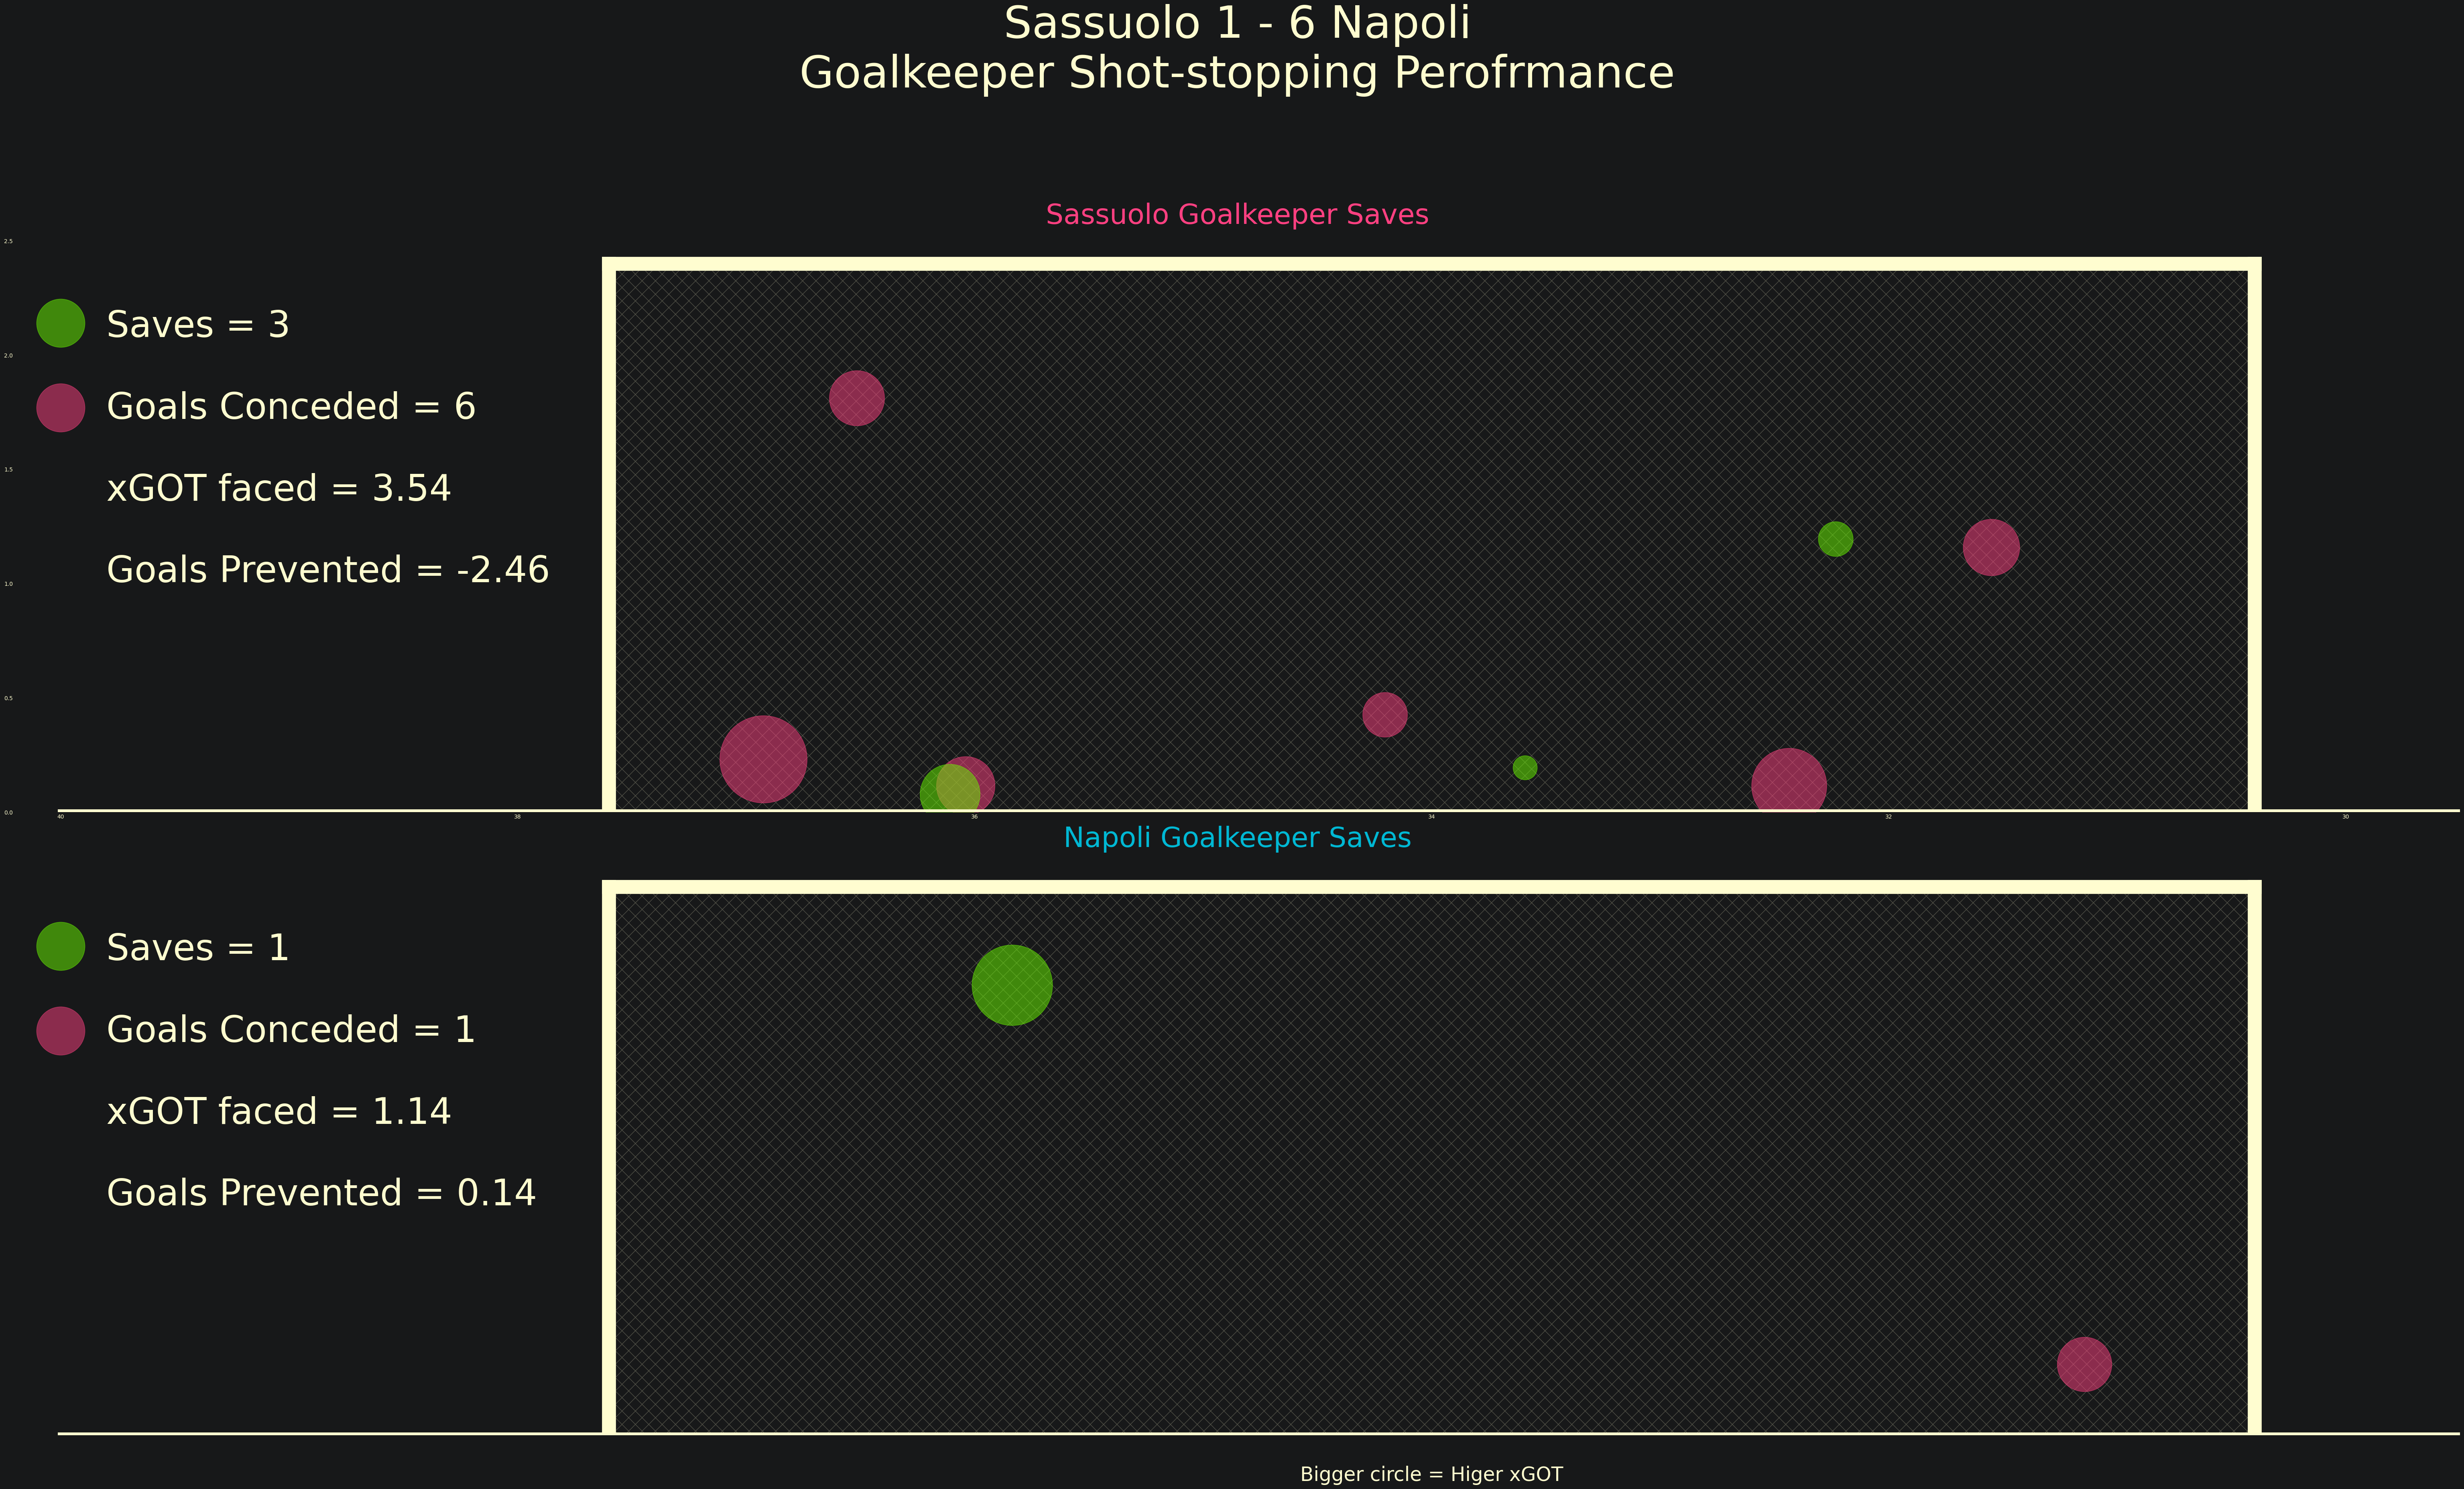

In [ ]:
# Create a square plot
fig, (ax1, ax2)= plt.subplots(2,1, figsize=(80, 32))
fig.set_facecolor(black)

def GoalPost(ax, teamID, teamName, col):
    ax=ax
    # Set aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')
    # Set axis limits
    ax.set_xlim(29.5, 40.2)
    ax.set_ylim(0, 2.55)
    ax.invert_xaxis()

    goalc_count = 0
    save_count = 0
    sf_count = 0

    xgot_faced = ShotsData[ShotsData['teamId'] != teamID]
    xgotf = xgot_faced['xgot'].sum().round(2)

    # Draw the lines
    ax.plot([30.4, 30.4], [0, 2.4], color=white, linewidth=25)
    ax.plot([30.4, 37.6], [2.4, 2.4], color=white, linewidth=25)
    ax.plot([37.6, 37.6], [2.4, 0], color=white, linewidth=25)
    ax.plot([28, 40], [0, 0], color=white, linewidth=10)
    # Draw the net
    rectangles = patches.Rectangle((30.4, 0), 7.2, 2.4, edgecolor=white, alpha=0.25, facecolor='none', hatch='x' * 1)
    ax.add_patch(rectangles)

    for index, row in ShotsData.iterrows():
        if row['teamId'] != teamID:
            if row['shotType'] == 'goal':
                ax.scatter(row['goalMouthY'], row['goalMouthZ'], color=red, s=(row['xgot']*25000)+1000, edgecolor=red, alpha=0.5)
                goalc_count += 1

            if row['shotType'] == 'save':
                s_value = row['xgot'] if not np.isnan(row['xgot']) else 0
                ax.scatter(row['goalMouthY'], row['goalMouthZ'], color=green, s=(s_value*25000)+1000, edgecolor=green, alpha=0.5)
                sf_count += 1

            if row['shotType'] == 'save':
                save_count += 1


    goals_prev = (xgotf - goalc_count).round(2)

    # Set the background color of the plot
    ax.set_facecolor(black)
    ax.scatter(40,2.14, color=green, s=7500, edgecolor=green, alpha=0.5)
    ax.scatter(40,1.77, color=red, s=7500, edgecolor=red, alpha=0.5)
    ax.text(39.8,2.2, f'Saves = {save_count}\n \nGoals Conceded = {goalc_count}\n \nxGOT faced = {xgotf}\n \nGoals Prevented = {goals_prev}', fontsize=65, color=white, ha='left', va='top')
    if teamID == ateamID:
      ax.text(34, -0.2, 'Bigger circle = Higer xGOT', fontsize=35, color=white, ha='center')

    ax.set_title(f"{teamName} Goalkeeper Saves", fontsize= 50, color=col)
    # Hide the spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide the ticks
    ax.tick_params(axis='both', which='both', color=black, length=0)
    # Hide tick labels on both axes
    plt.xticks([], color=black)
    plt.yticks([], color=black)
    plt.axis('off')

    return fig, ax

# Plot the first subplot using GoalPost function
GoalPost(ax1, hteamID, hteamName, hcol)
GoalPost(ax2, ateamID, ateamName, acol)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle(f'{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nGoalkeeper Shot-stopping Perofrmance', color=white, fontsize=80, y=1.15)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}GoalKeeper_Shotstopping.png', bbox_inches='tight')

# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}GoalKeeper_Shotstopping.png')

xG Flow (sofascore)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

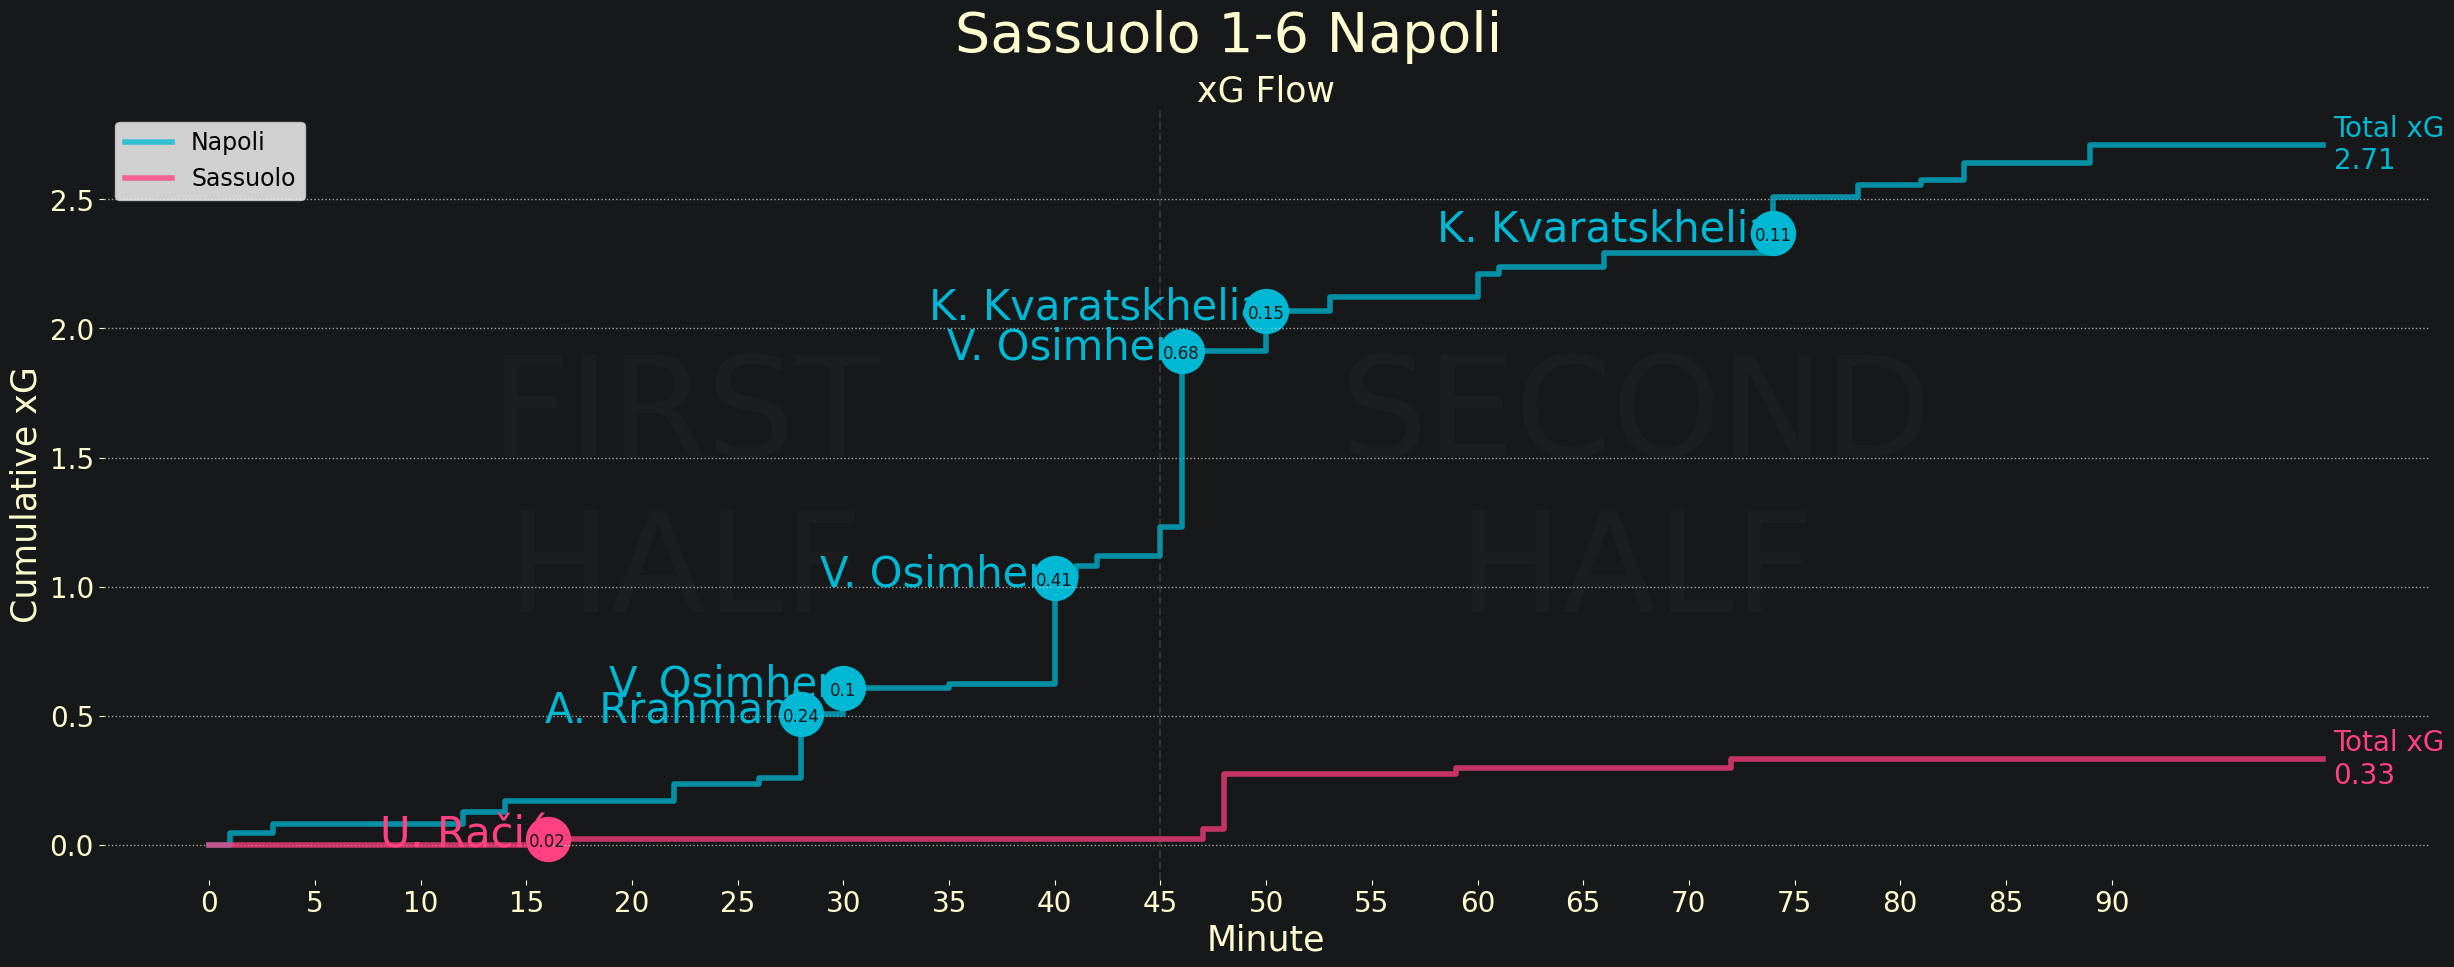

In [ ]:
a_xg = [0]
h_xg = [0]
a_min = [0]
h_min = [0]

for x in range(len(ShotsData['xg'])):
    if ShotsData['teamId'][x]==ateamID:
        a_xg.append(ShotsData['xg'][x])
        a_min.append(ShotsData['minute'][x])
    if ShotsData['teamId'][x]==hteamID:
        h_xg.append(ShotsData['xg'][x])
        h_min.append(ShotsData['minute'][x])

#this is the function we use to make our xg values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xg)
h_cumulative = nums_cumulative_sum(h_xg)

# Add final points to cumulative xG lists for both teams at the 90th minute
a_cumulative.append(a_cumulative[-1])
h_cumulative.append(h_cumulative[-1])
a_min.append(100)
h_min.append(100)

#this is used to find the total xg. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

fig, ax = plt.subplots(figsize = (30,10))
fig.set_facecolor(black)
ax.patch.set_facecolor(black)

#set up our base layer
mpl.rcParams['xtick.color'] = white
mpl.rcParams['ytick.color'] = white

ax.grid(ls='dotted',lw=1,color='lightgrey',axis='y',zorder=1,alpha=0.75)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90], color=white, fontsize=20)
plt.yticks(color=white, fontsize=20)
plt.xlabel('Minute',color=white,fontsize=25)
plt.ylabel('Cumulative xG',color=white,fontsize=25)
plt.suptitle(f'{hteamName} {hgoal_count}-{agoal_count} {ateamName}', color=white, fontsize=40)
plt.title('xG Flow', color=white, fontsize=25)

#plot the step graphs
ax.step(x=a_min,y=a_cumulative,color=acol,label=ateamName,linewidth=4,where='post',alpha=0.75)
ax.step(x=h_min,y=h_cumulative,color=hcol,label=hteamName,linewidth=4,where='post',alpha=0.75)

# Filter data for goals of the teams
h_goals_data = ShotsData[(ShotsData['shotType'] == 'goal') & (ShotsData['teamId'] == hteamID) & (ShotsData['goalType'] != 'own ')]
a_goals_data = ShotsData[(ShotsData['shotType'] == 'goal') & (ShotsData['teamId'] == ateamID) & (ShotsData['goalType'] != 'own ')]

# Extract minute and cumulative xG for the teams goals
h_x = h_goals_data['minute'].tolist()
a_x = a_goals_data['minute'].tolist()
h_x_indices = [h_min.index(minute) for minute in h_x]
a_x_indices = [a_min.index(minute) for minute in a_x]

# Scatter plot for team goals
ax.scatter(x=[h_min[i] for i in h_x_indices], y=[h_cumulative[i] for i in h_x_indices], color=hcol, marker='o', s=1000)
ax.scatter(x=[a_min[i] for i in a_x_indices], y=[a_cumulative[i] for i in a_x_indices], color=acol, marker='o', s=1000)

# Annotate with player names
for i, txt in enumerate(h_goals_data['shortName']):
    ax.annotate(txt, (h_min[h_x_indices[i]], h_cumulative[h_x_indices[i]]+0.07), textcoords="offset points", xytext=(0,5), ha='right',va='top', color=hcol, fontsize=30)
for i, txt in enumerate(a_goals_data['shortName']):
    ax.annotate(txt, (a_min[a_x_indices[i]], a_cumulative[a_x_indices[i]]+0.07), textcoords="offset points", xytext=(0,5), ha='right',va='top', color=acol, fontsize=30)

# Annotate with xg
for i, txt in enumerate(h_goals_data['xg'].round(2)):
    ax.annotate(txt, (h_min[h_x_indices[i]], h_cumulative[h_x_indices[i]]), textcoords="offset points", xytext=(0,5), ha='center',va='top', color=black, fontsize=12)
for i, txt in enumerate(a_goals_data['xg'].round(2)):
    ax.annotate(txt, (a_min[a_x_indices[i]], a_cumulative[a_x_indices[i]]), textcoords="offset points", xytext=(0,5), ha='center',va='top', color=black, fontsize=12)
# Annotate final cumulative xG values
ax.text(100.5, a_cumulative[-1], f'Total xG\n{alast}', color=acol, ha='left', va='center', fontsize=20)
ax.text(100.5, h_cumulative[-1], f'Total xG\n{hlast}', color=hcol, ha='left', va='center', fontsize=20)

plt.axvline(x=45, color='gray', linestyle='--', alpha=0.25)

if hxG >= axG:
  plt.text(22.5, (hxG/2), "FIRST\nHALF", fontsize=100, color='gray', ha='center', va='center', alpha=0.05)
  plt.text(67.5, (hxG/2), "SECOND\nHALF", fontsize=100, color='gray', ha='center', va='center', alpha=0.05)
else:
  plt.text(22.5, (axG/2), "FIRST\nHALF", fontsize=100, color='gray', ha='center', va='center', alpha=0.05)
  plt.text(67.5, (axG/2), "SECOND\nHALF", fontsize=100, color='gray', ha='center', va='center', alpha=0.05)

plt.legend(loc='upper left', prop={'size': 17})

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}xG_Flow.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}xG_Flow.png')

Teams Progressive Passes



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-27-b184ac4e304c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpro['cluster'] = kmeans.predict(X)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-27-b184ac4e304c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

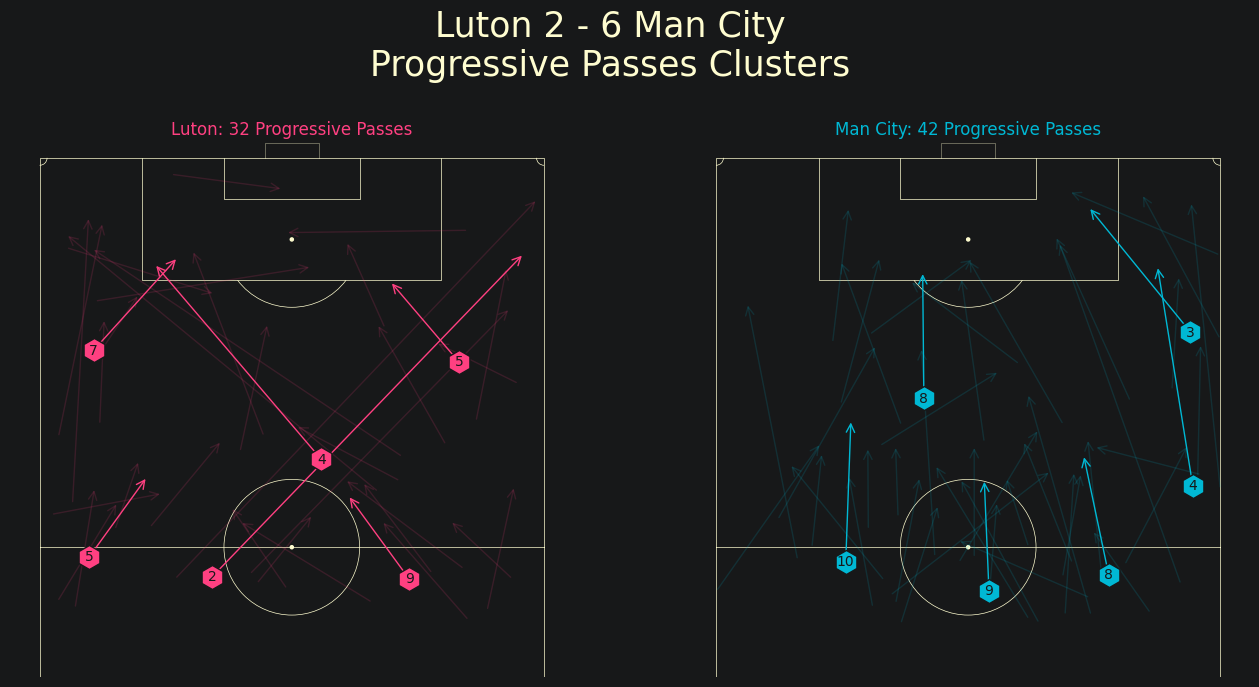

In [ ]:
mask = df['teamId'] == ateamID
dfapp = df[mask]
dfapp = dfapp.loc[dfapp['type'] == "Pass"]
dfapp = dfapp[~dfapp['qualifiers'].str.contains('Corner')]

mask = df['teamId'] == hteamID
dfhpp = df[mask]
dfhpp = dfhpp.loc[dfhpp['type'] == "Pass"]
dfhpp = dfhpp[~dfhpp['qualifiers'].str.contains('Corner')]
# Create two separate figures and axes with a black background
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), facecolor=black)
# Create a function to draw the shot maps
def draw_progressive_pass_map(ax, df, title, col):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=black, line_color=white, linewidth=0.5,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.set_ylim(35,107)

    dfpro = df[df['pro'] >= 9.144]
    pro_count = len(dfpro)

    X = np.array(dfpro[['x','y','endX','endY']])
    kmeans = KMeans(n_clusters = 6, random_state = 100)
    kmeans.fit(X)
    dfpro['cluster'] = kmeans.predict(X)

    cluster1 = dfpro[dfpro['cluster'] == 0]
    cluster2 = dfpro[dfpro['cluster'] == 1]
    cluster3 = dfpro[dfpro['cluster'] == 2]
    cluster4 = dfpro[dfpro['cluster'] == 3]
    cluster5 = dfpro[dfpro['cluster'] == 4]
    cluster6 = dfpro[dfpro['cluster'] == 5]

    qty1 = len(cluster1)
    qty2 = len(cluster2)
    qty3 = len(cluster3)
    qty4 = len(cluster4)
    qty5 = len(cluster5)
    qty6 = len(cluster6)

    for index, row in dfpro.iterrows():
        if row['cluster'] == 0:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=col, alpha=0.15)
            ax.add_patch(arrow)
        if row['cluster'] == 1:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=col, alpha=0.15)
            ax.add_patch(arrow)
        if row['cluster'] == 2:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=col, alpha=0.15)
            ax.add_patch(arrow)
        if row['cluster'] == 3:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=col, alpha=0.15)
            ax.add_patch(arrow)
        if row['cluster'] == 4:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=col, alpha=0.15)
            ax.add_patch(arrow)
        if row['cluster'] == 5:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=15, color=col, alpha=0.15)
            ax.add_patch(arrow)

    arrow1 = patches.FancyArrowPatch((cluster1['x'].mean(), cluster1['y'].mean()), (cluster1['endX'].mean(), cluster1['endY'].mean()), arrowstyle='->', mutation_scale=15, color=col)
    arrow2 = patches.FancyArrowPatch((cluster2['x'].mean(), cluster2['y'].mean()), (cluster2['endX'].mean(), cluster2['endY'].mean()), arrowstyle='->', mutation_scale=15, color=col)
    arrow3 = patches.FancyArrowPatch((cluster3['x'].mean(), cluster3['y'].mean()), (cluster3['endX'].mean(), cluster3['endY'].mean()), arrowstyle='->', mutation_scale=15, color=col)
    arrow4 = patches.FancyArrowPatch((cluster4['x'].mean(), cluster4['y'].mean()), (cluster4['endX'].mean(), cluster4['endY'].mean()), arrowstyle='->', mutation_scale=15, color=col)
    arrow5 = patches.FancyArrowPatch((cluster5['x'].mean(), cluster5['y'].mean()), (cluster5['endX'].mean(), cluster5['endY'].mean()), arrowstyle='->', mutation_scale=15, color=col)
    arrow6 = patches.FancyArrowPatch((cluster6['x'].mean(), cluster6['y'].mean()), (cluster6['endX'].mean(), cluster6['endY'].mean()), arrowstyle='->', mutation_scale=15, color=col)
    ax.add_patch(arrow1)
    ax.add_patch(arrow2)
    ax.add_patch(arrow3)
    ax.add_patch(arrow4)
    ax.add_patch(arrow5)
    ax.add_patch(arrow6)

    ax.scatter(cluster1['x'].mean(), cluster1['y'].mean(), s=300, color=col, marker='h', edgecolor=black)
    ax.scatter(cluster2['x'].mean(), cluster2['y'].mean(), s=300, color=col, marker='h', edgecolor=black)
    ax.scatter(cluster3['x'].mean(), cluster3['y'].mean(), s=300, color=col, marker='h', edgecolor=black)
    ax.scatter(cluster4['x'].mean(), cluster4['y'].mean(), s=300, color=col, marker='h', edgecolor=black)
    ax.scatter(cluster5['x'].mean(), cluster5['y'].mean(), s=300, color=col, marker='h', edgecolor=black)
    ax.scatter(cluster6['x'].mean(), cluster6['y'].mean(), s=300, color=col, marker='h', edgecolor=black)

    ax.text(cluster1['x'].mean(), cluster1['y'].mean(), f'{qty1}', fontsize=10, color=black, va='center', ha='center')
    ax.text(cluster2['x'].mean(), cluster2['y'].mean(), f'{qty2}', fontsize=10, color=black, va='center', ha='center')
    ax.text(cluster3['x'].mean(), cluster3['y'].mean(), f'{qty3}', fontsize=10, color=black, va='center', ha='center')
    ax.text(cluster4['x'].mean(), cluster4['y'].mean(), f'{qty4}', fontsize=10, color=black, va='center', ha='center')
    ax.text(cluster5['x'].mean(), cluster5['y'].mean(), f'{qty5}', fontsize=10, color=black, va='center', ha='center')
    ax.text(cluster6['x'].mean(), cluster6['y'].mean(), f'{qty6}', fontsize=10, color=black, va='center', ha='center')

    counttext = f"{title}: {pro_count} Progressive Passes"
    ax.set_title(counttext, color=col, fontsize=12)


draw_progressive_pass_map(ax1, dfhpp, hteamName, hcol)
draw_progressive_pass_map(ax2, dfapp, ateamName, acol)

plt.suptitle(f'{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nProgressive Passes Clusters', fontsize=25, color=white, y=0.94)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Progressive_Passes_Cluster.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Progressive_Passes_Cluster.png')

Zone14 & Halfspaces



In [ ]:
dfhp = df.loc[df['teamId'] == hteamID]
dfhp = dfhp.loc[dfhp['type'] == "Pass"]
dfhp = dfhp.loc[dfhp['outcomeType'] == "Successful"]
dfhp = dfhp[~dfhp['qualifiers'].str.contains('Corner')]

dfap = df.loc[df['teamId'] == ateamID]
dfap = dfap.loc[dfap['type'] == "Pass"]
dfap = dfap.loc[dfap['outcomeType'] == "Successful"]
dfap = dfap[~dfap['qualifiers'].str.contains('Corner')]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

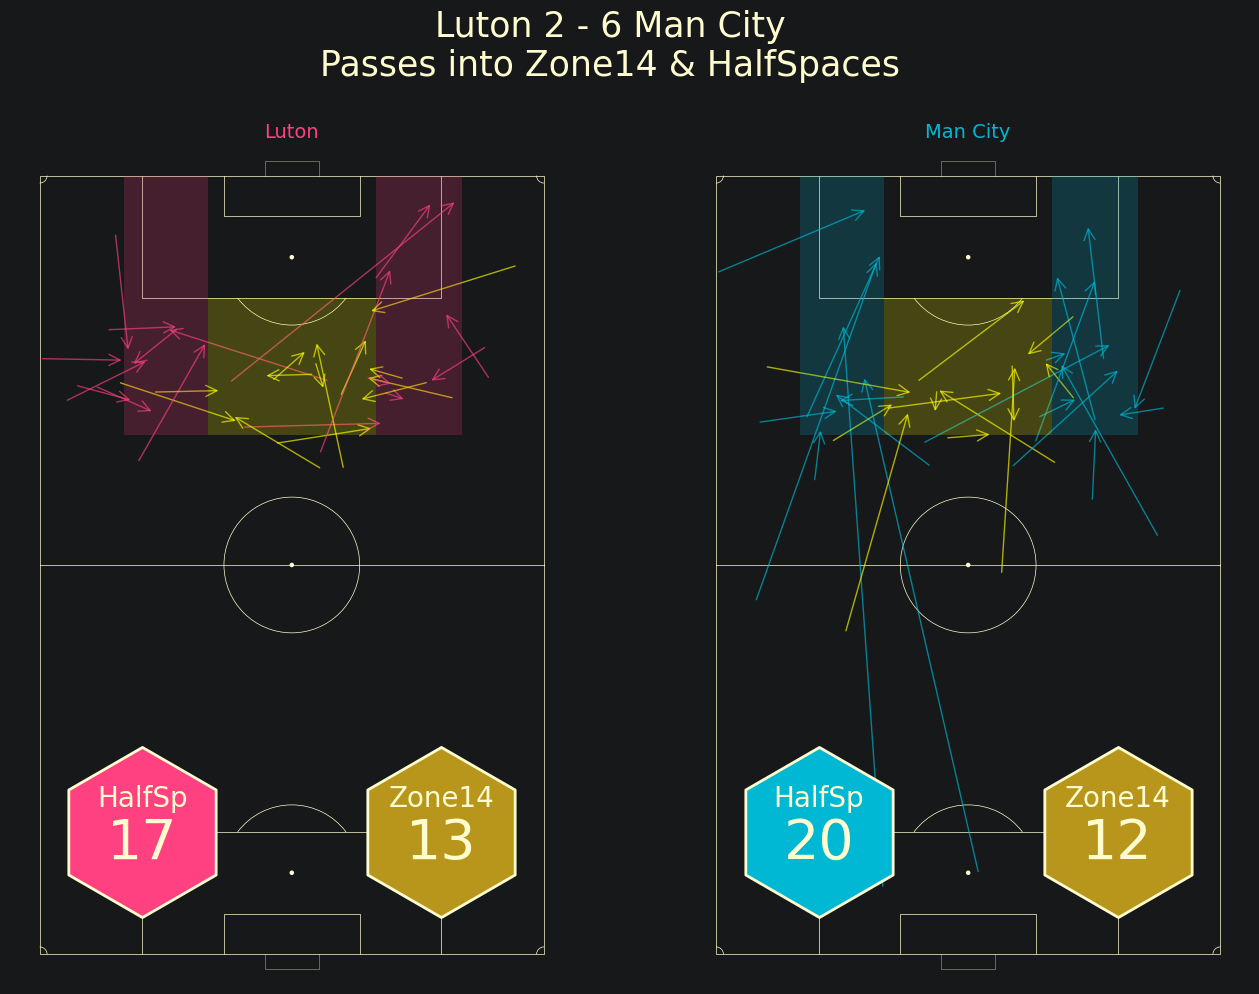

In [ ]:
# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor=black)

# Create a function to draw the shot maps
def draw_pass_map(ax, df, title, col):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=black, line_color=white,  linewidth=0.5,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.invert_xaxis()
    ax.set_facecolor(black)

    z14 = 0
    hs = 0

    for index, row in df.iterrows():
        if row['endY'] >= 70 and row['endY'] <= 88.54 and row['endX'] >= 22.66 and row['endX'] <= 45.32:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            z14 += 1
        if row['endY'] >= 70 and row['endX'] >= 11.33 and row['endX'] <= 22.66:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color=col, linewidth=1)
            ax.add_patch(arrow)
            hs += 1
        if row['endY'] >= 70 and row['endX'] >= 45.32 and row['endX'] <= 56.95:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color=col, linewidth=1)
            ax.add_patch(arrow)
            hs += 1

    x_z14 = [22.66, 22.66, 45.32, 45.32]
    y_z14 = [70, 88.54, 88.54, 70]
    ax.fill(x_z14, y_z14, 'yellow', alpha=0.2, label='Zone14')

    x_rhs = [11.33, 11.33, 22.66, 22.66]
    y_rhs = [70, 105, 105, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    x_lhs = [45.32, 45.32, 56.95, 56.95]
    y_lhs = [70, 105, 105, 70]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(13.85, 16.46, color=col, s=15000, edgecolor=white, linewidth=2, alpha=1, marker='h')
    ax.scatter(54.15, 16.46, color='#b8961b', s=15000, edgecolor=white, linewidth=2, alpha=1, marker='h')
    ax.text(13.85, 21, hsname, fontsize=20, color=white, ha='center', va='center')
    ax.text(54.15, 21, z14name, fontsize=20, color=white, ha='center', va='center')
    ax.text(13.85, 15, hscount, fontsize=40, color=white, ha='center', va='center')
    ax.text(54.15, 15, z14count, fontsize=40, color=white, ha='center', va='center')
    ax.set_title(title, color=col, fontsize=14)


draw_pass_map(axs[0], dfhp, hteamName, hcol)
draw_pass_map(axs[1], dfap, ateamName, acol)

plt.suptitle(f'{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nPasses into Zone14 & HalfSpaces', fontsize=25, color=white, y=1)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Passes_into_Danger_zone.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Passes_into_Danger_zone.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

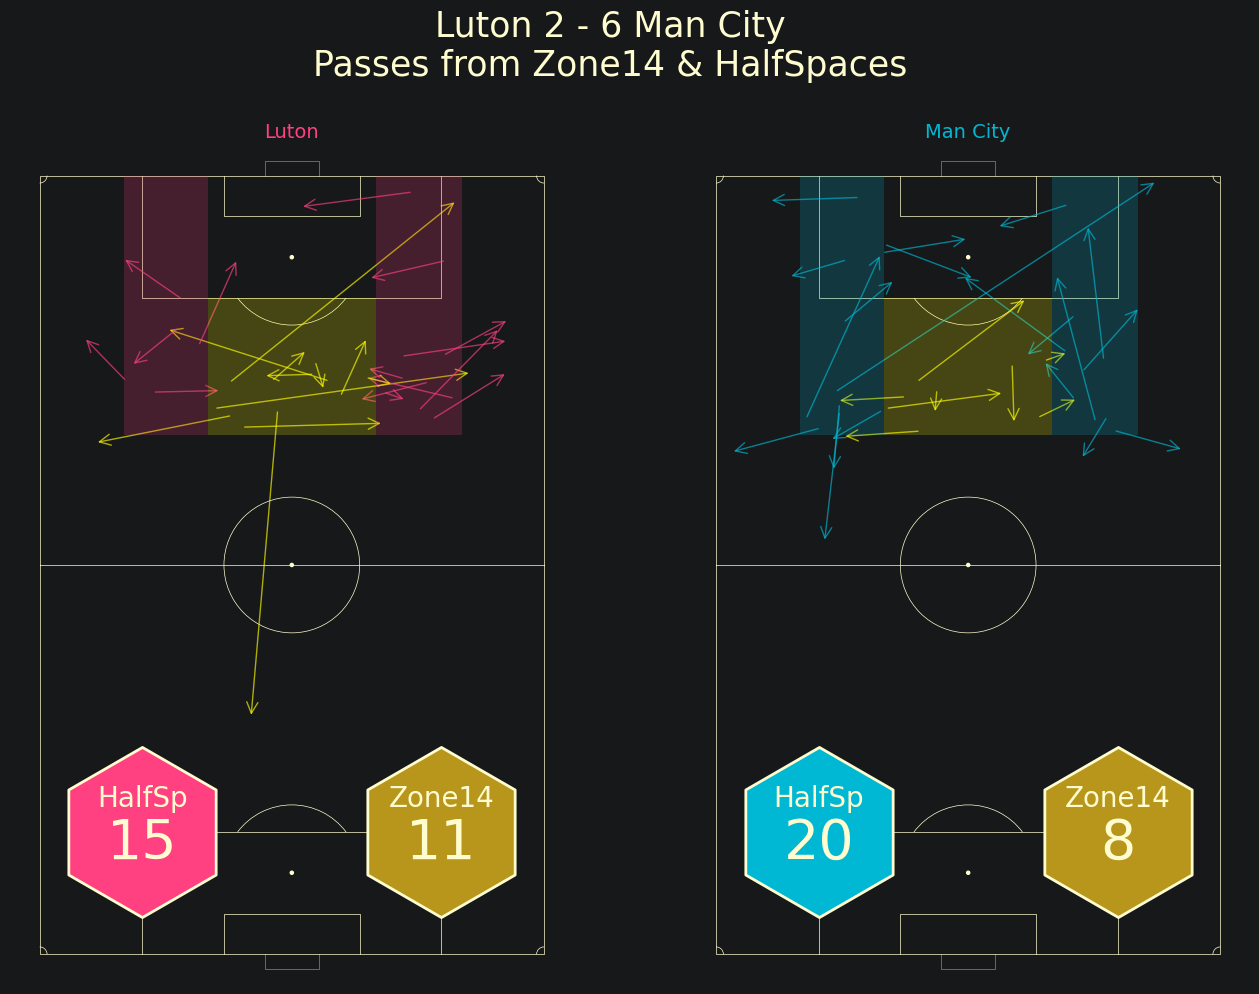

In [ ]:
# Create a figure with a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 11), facecolor=black)

# Create a function to draw the shot maps
def draw_pass_map(ax, df, title, col):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=black, line_color=white, linewidth=0.5,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.invert_xaxis()
    ax.set_facecolor(black)

    z14 = 0
    hs = 0

    for index, row in df.iterrows():
        if row['y'] >= 70 and row['y'] <= 88.54 and row['x'] >= 22.66 and row['x'] <= 45.32:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color='yellow', linewidth=1)
            ax.add_patch(arrow)
            z14 += 1
        if row['y'] >= 70 and row['x'] >= 11.33 and row['x'] <= 22.66:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color=col, linewidth=1)
            ax.add_patch(arrow)
            hs += 1
        if row['y'] >= 70 and row['x'] >= 45.32 and row['x'] <= 56.95:
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', alpha=0.65, mutation_scale=20, color=col, linewidth=1)
            ax.add_patch(arrow)
            hs += 1

    x_z14 = [22.66, 22.66, 45.32, 45.32]
    y_z14 = [70, 88.54, 88.54, 70]
    ax.fill(x_z14, y_z14, 'yellow', alpha=0.2, label='Zone14')

    x_rhs = [11.33, 11.33, 22.66, 22.66]
    y_rhs = [70, 105, 105, 70]
    ax.fill(x_rhs, y_rhs, col, alpha=0.2, label='HalfSpaces')

    x_lhs = [45.32, 45.32, 56.95, 56.95]
    y_lhs = [70, 105, 105, 70]
    ax.fill(x_lhs, y_lhs, col, alpha=0.2, label='HalfSpaces')

    z14name = "Zone14"
    hsname = "HalfSp"
    z14count = f"{z14}"
    hscount = f"{hs}"
    ax.scatter(13.85, 16.46, color=col, s=15000, edgecolor=white, linewidth=2, alpha=1, marker='h')
    ax.scatter(54.15, 16.46, color='#b8961b', s=15000, edgecolor=white, linewidth=2, alpha=1, marker='h')
    ax.text(13.85, 21, hsname, fontsize=20, color=white, ha='center', va='center')
    ax.text(54.15, 21, z14name, fontsize=20, color=white, ha='center', va='center')
    ax.text(13.85, 15, hscount, fontsize=40, color=white, ha='center', va='center')
    ax.text(54.15, 15, z14count, fontsize=40, color=white, ha='center', va='center')
    ax.set_title(title, color=col, fontsize=14)


draw_pass_map(axs[0], dfhp, hteamName, hcol)
draw_pass_map(axs[1], dfap, ateamName, acol)

plt.suptitle(f'{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nPasses from Zone14 & HalfSpaces', fontsize=25, color=white, y=1)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Passes_from_Danger_zone.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Passes_from_Danger_zone.png')

Pass End Zone



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

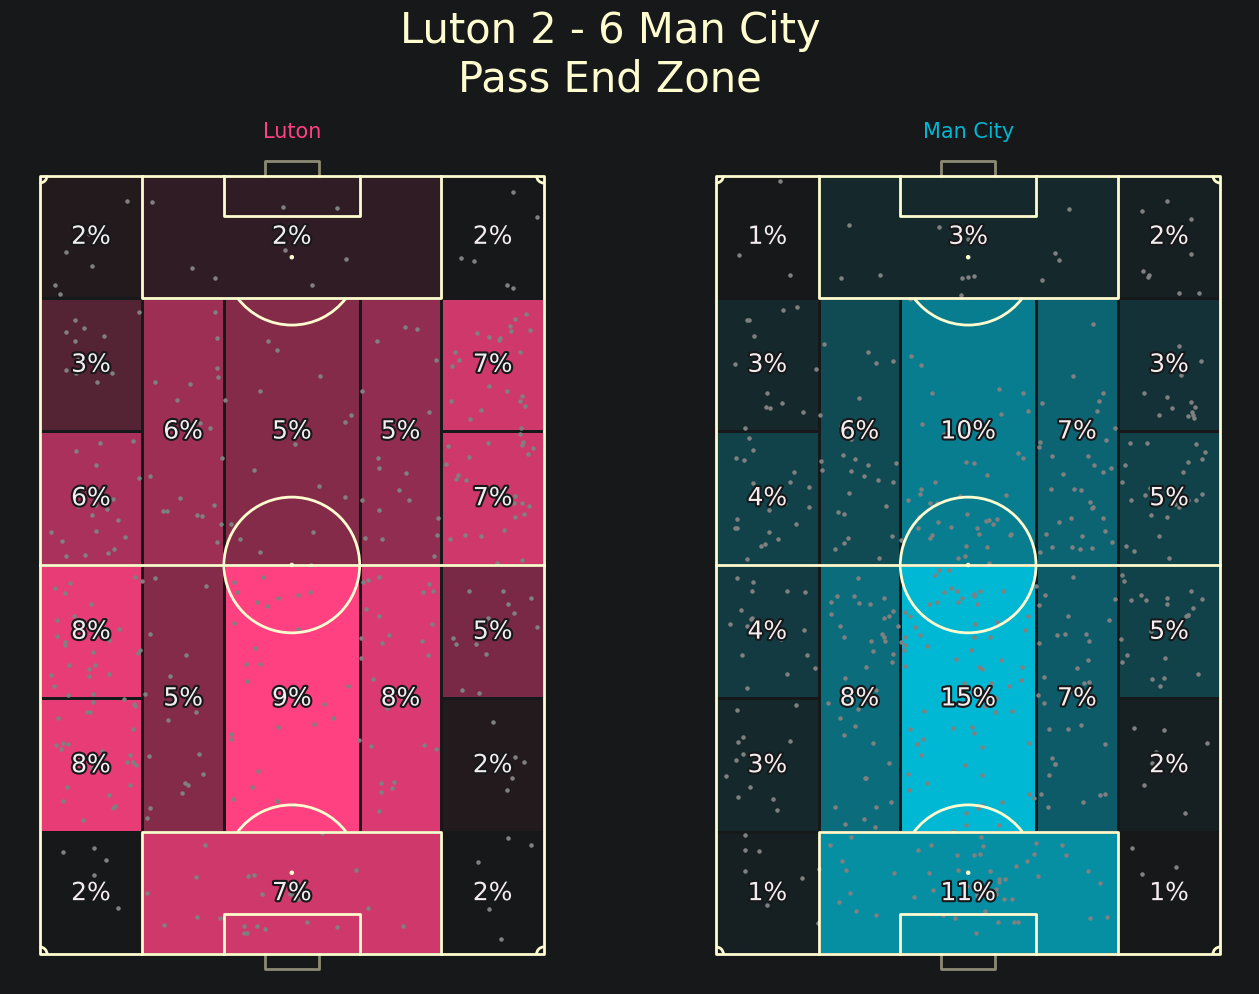

In [ ]:
mask = (df['teamId'] == hteamID) & (df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')
hdfPEZ = df[mask]
mask = (df['teamId'] == ateamID) & (df['type'] == 'Pass') & (df['outcomeType'] == 'Successful')
adfPEZ = df[mask]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       [black, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       [black, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=black),
            path_effects.Normal()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 11), facecolor=black)

def Pass_end_zone(ax, df, title, cm, tcm):
    pitch = VerticalPitch(pitch_type='uefa', line_color=white, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=black)
    pitch.draw(ax=ax)

    pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic_positional(df.endY, df.endX, statistic='count', positional='full', normalize=True)
    pitch.heatmap_positional(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors=black)
    pitch.scatter(df.endY, df.endX, c='#808080', s=5, ax=ax)
    labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18, ax=ax, ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)
    teamName = title
    ax.set_title(teamName, color=tcm, fontsize=15)

Pass_end_zone(ax1, hdfPEZ, hteamName, pearl_earring_cmaph, hcol)
Pass_end_zone(ax2, adfPEZ, ateamName, pearl_earring_cmapa, acol)

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nPass End Zone", fontsize=30, color=white, y=1)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Pass_Ending_Zone.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Pass_Ending_Zone.png')

Crosses



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

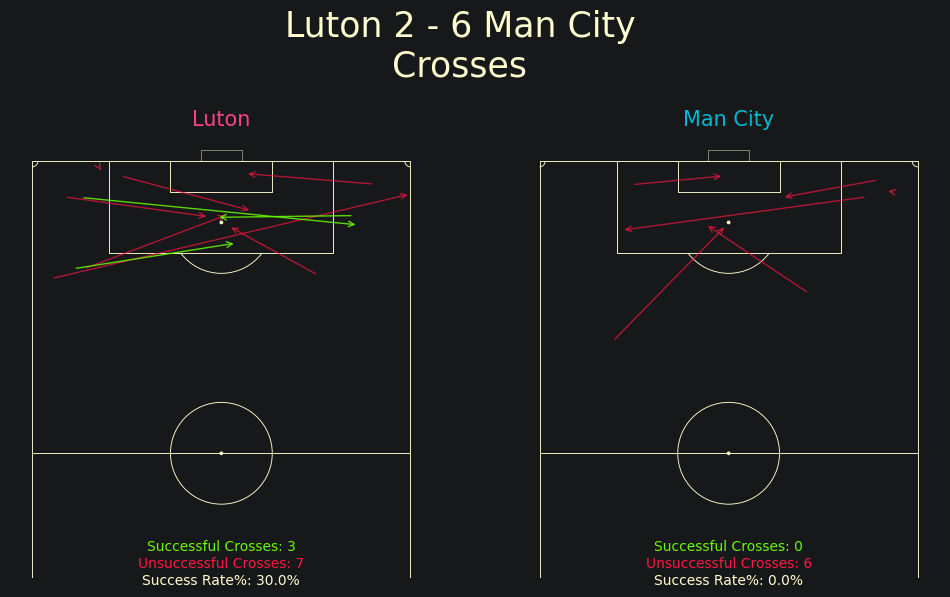

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 9), facecolor=black)

def plot_crosses(ax, teamId, teamName, col):
    pitch = VerticalPitch(pitch_type='uefa', goal_type='box', goal_alpha=.5, corner_arcs=True,
                      pitch_color=black, line_color=white, linewidth=0.65)
    pitch.draw(ax=ax)
    ax.set_ylim(30,110)

    awin = 0
    aloss = 0

    for index, row in df.iterrows():
      if (
        row['teamId'] == teamId and
        row['type'] == 'Pass' and
        row['outcomeType'] == 'Successful' and
        'Cross' in row['qualifiers'] and
        'Corner' not in row['qualifiers']
      ):
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=10, color=green, linewidth=1, alpha=.85)
        ax.add_patch(arrow)
        awin += 1
      if (
        row['teamId'] == teamId and
        row['type'] == 'Pass' and
        row['outcomeType'] == 'Unsuccessful' and
        'Cross' in row['qualifiers'] and
        'Corner' not in row['qualifiers']
      ):
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=10, color='#ff1744', linewidth=1, alpha=.65)
        ax.add_patch(arrow)
        aloss += 1

    total = awin + aloss
    if total != 0:
        win = round((awin / total) * 100, 2)
    else:
        win = 0.0
    ax.set_title(f"{teamName}", color=col, fontsize=15)
    ax.text(34, 35, f"Successful Crosses: {awin}", color=green, fontsize=10, ha='center')
    ax.text(34, 32, f"Unsuccessful Crosses: {aloss}", color='#ff1744', fontsize=10, ha='center')
    ax.text(34, 29, f"Success Rate%: {win}%", color=white, fontsize=10, ha='center')

plot_crosses(axs[0], hteamID, hteamName, hcol)
plot_crosses(axs[1], ateamID, ateamName, acol)

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nCrosses", fontsize=25, color=white, y=0.88)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Crosses.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Crosses.png')

Chance Creating Zone



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

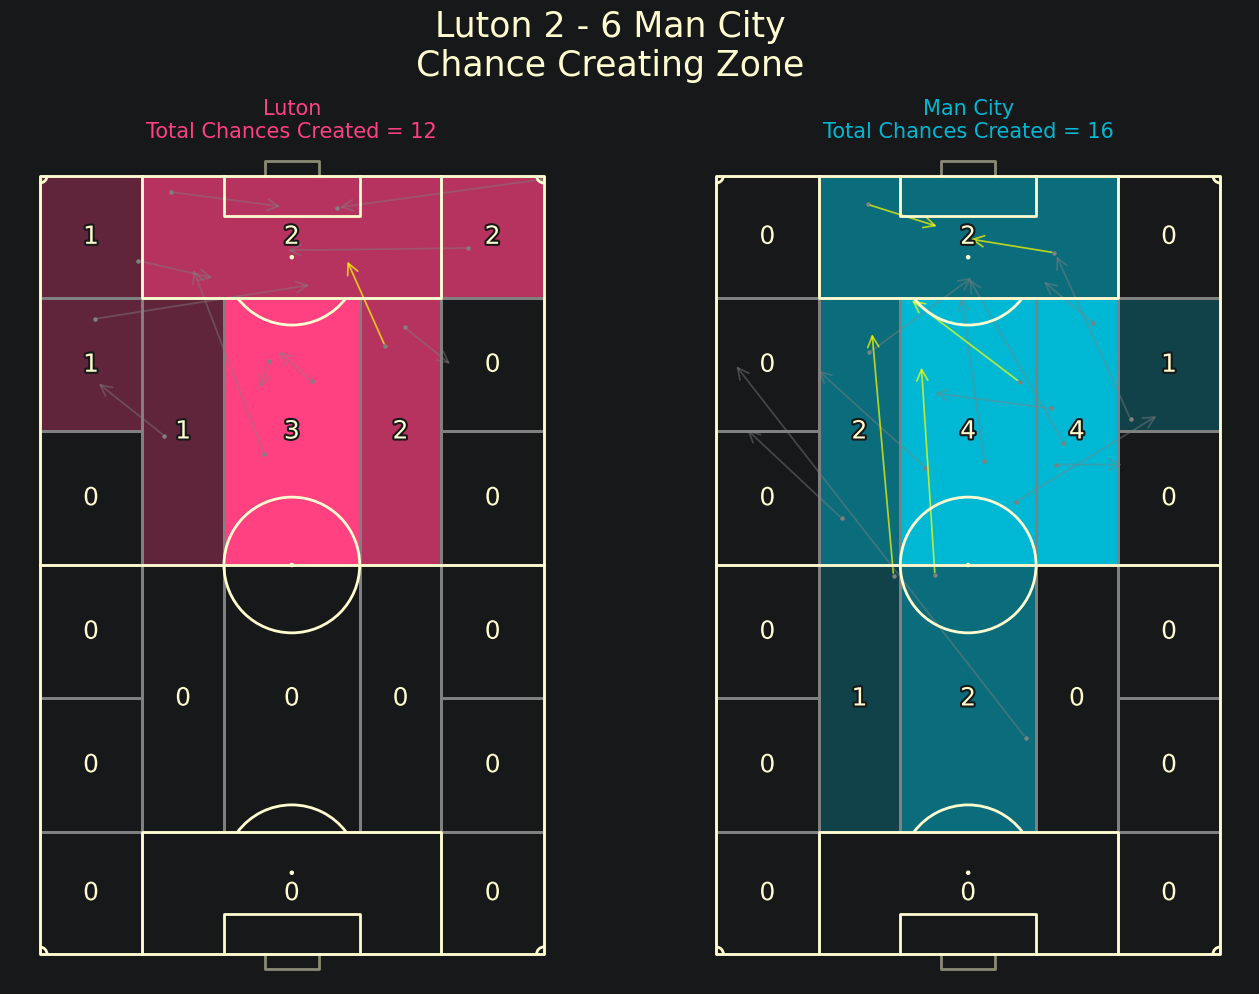

In [ ]:
mask = (df['teamId'] == hteamID) & (df['qualifiers'].str.contains('KeyPass', na=False))
dfchch = df[mask]
mask = (df['teamId'] == ateamID) & (df['qualifiers'].str.contains('KeyPass', na=False))
dfchca = df[mask]

# see the custom colormaps example for more ideas on setting colormaps
pearl_earring_cmaph = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [black, hcol], N=20)
pearl_earring_cmapa = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors", [black, acol], N=20)

path_eff = [path_effects.Stroke(linewidth=3, foreground=black), path_effects.Normal()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 11), facecolor=black)

def Chance_creating_zone(ax, df, title, cm, tcm):
    pitch = VerticalPitch(pitch_type='uefa', line_color=white, goal_type='box', goal_alpha=.5, corner_arcs=True, line_zorder=2, pitch_color=black)
    pitch.draw(ax=ax)

    cc = 0
    pearl_earring_cmap = cm
    bin_statistic = pitch.bin_statistic_positional(df.y, df.x, statistic='count', positional='full', normalize=False)
    pitch.heatmap_positional(bin_statistic, ax=ax, cmap=pearl_earring_cmap, edgecolors='#808080')
    pitch.scatter(df.y, df.x, c='gray', s=5, ax=ax)
    for index, row in df.iterrows():
      if 'IntentionalGoalAssist' in row['qualifiers']:
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1.25, alpha=0.7)
        ax.add_patch(arrow)
        cc += 1
      else :
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='gray', linewidth=1.25, alpha=0.45)
        ax.add_patch(arrow)
        cc += 1
    labels = pitch.label_heatmap(bin_statistic, color=white, fontsize=18, ax=ax, ha='center', va='center', str_format='{:.0f}', path_effects=path_eff)
    teamName = title
    ax.set_title(f"{teamName}\nTotal Chances Created = {cc}", color=tcm, fontsize=15)

Chance_creating_zone(ax1, dfchch, hteamName, pearl_earring_cmaph, hcol)
Chance_creating_zone(ax2, dfchca, ateamName, pearl_earring_cmapa, acol)

plt.suptitle(f'{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nChance Creating Zone', fontsize=25, color=white, y=1)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Chances_creating_zone.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Chances_creating_zone.png')

Defensive Block

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

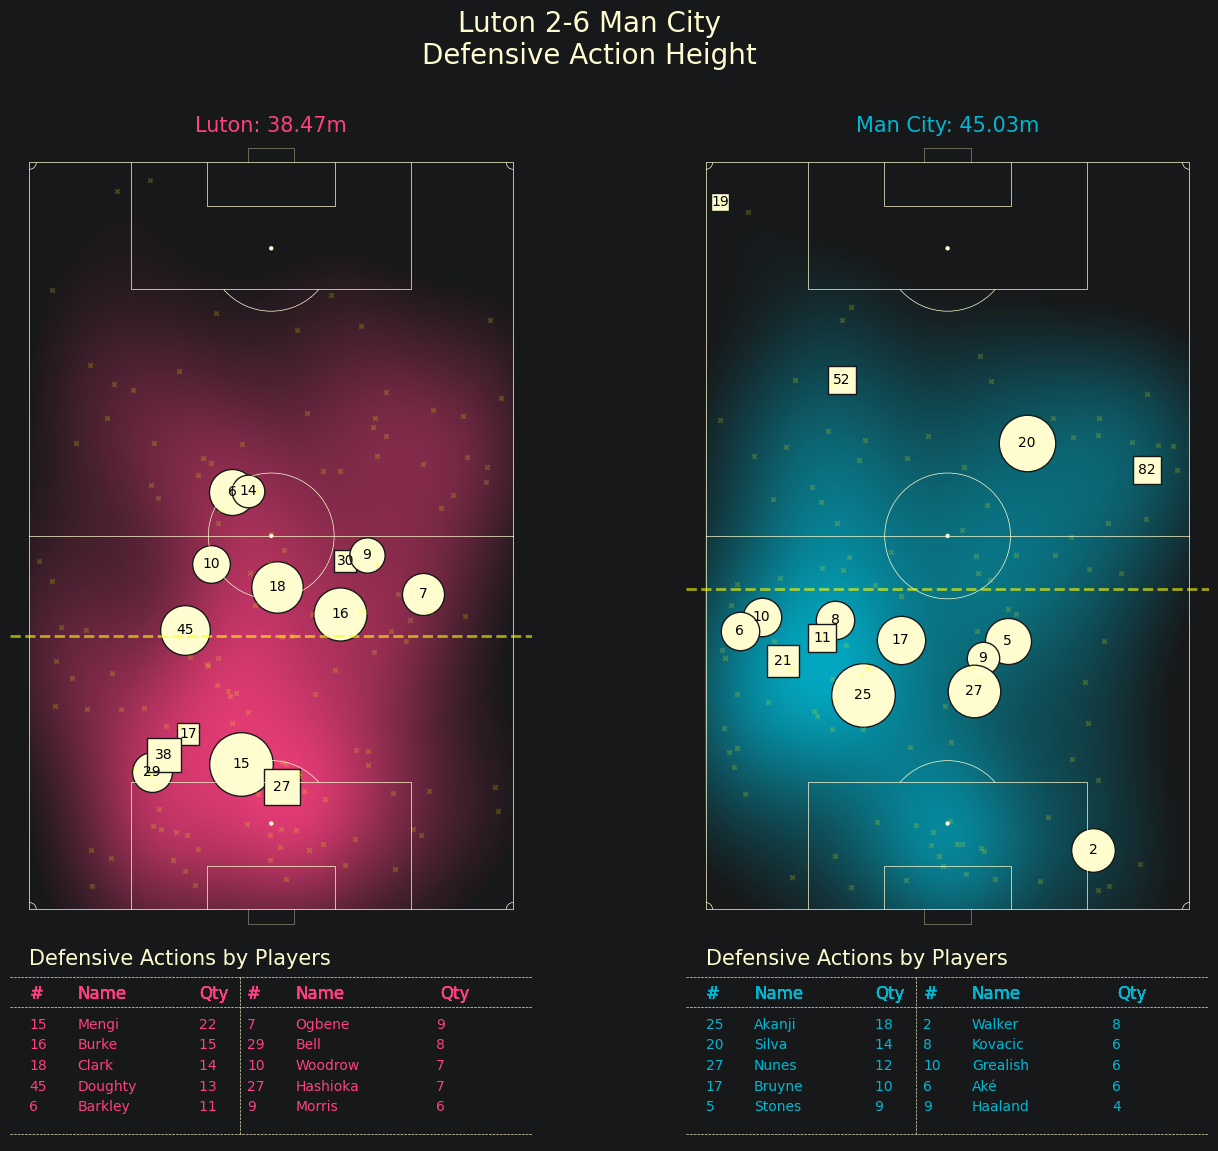

In [ ]:
def get_defensive_action_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # filter only defensive actions
    defensive_actions_ids = df.index[(df['eventType'] == 'Aerial') & (df['x'] <= 80) |
                                     (df['eventType'] == 'BallRecovery') |
                                     (df['eventType'] == 'BlockedPass') |
                                     (df['eventType'] == 'Challenge') |
                                     (df['eventType'] == 'Clearance') |
                                     (df['eventType'] == 'Error') |
                                     (df['eventType'] == 'Foul') |
                                     (df['eventType'] == 'Interception') |
                                     (df['eventType'] == 'Tackle')]
    df_defensive_actions = df.loc[defensive_actions_ids, ["id", "x", "y", "teamId", "playerId", "eventType", "outcomeType"]]

    return df_defensive_actions

defensive_actions_df = get_defensive_action_df(events_dict)

def get_da_count_df(team_id, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df["teamId"] == team_id]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    return  average_locs_and_count_df

home_average_locs_and_count_df = get_da_count_df(hteamID, defensive_actions_df, players_df)
away_average_locs_and_count_df = get_da_count_df(ateamID, defensive_actions_df, players_df)
home_average_locs_and_count_df = home_average_locs_and_count_df[home_average_locs_and_count_df['position'] != 'GK']
away_average_locs_and_count_df = away_average_locs_and_count_df[away_average_locs_and_count_df['position'] != 'GK']

fig, axs = plt.subplots(1, 2, figsize=(16, 13), facecolor=black)

def defensive_block(ax, average_locs_and_count_df, title, team_id, col):
  defensive_actions_team_df = defensive_actions_df[defensive_actions_df["teamId"] == team_id]
  pitch = VerticalPitch(pitch_type='opta', pitch_color=black, line_color=white,  linewidth=0.5, line_zorder=2, corner_arcs=True, goal_type='box', goal_alpha=.5)
  pitch.draw(ax=ax)
  ax.set_facecolor(black)
  ax.set_ylim(-31,103)

  MAX_MARKER_SIZE = 2000
  average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)
  color = np.array(to_rgba(col))
  flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
                                                  [black, col], N=500)
  kde = pitch.kdeplot(defensive_actions_team_df.x, defensive_actions_team_df.y, ax=ax, fill=True, levels=5000, thresh=0.02, cut=4, cmap=flamingo_cmap)

  x_blc = [0, 0, 100, 100]
  y_blc = [0, 100, 100, 0]
  ax.fill(x_blc, y_blc, black, alpha=0.1)

  for index, row in average_locs_and_count_df.iterrows():
    if row['isFirstEleven'] == True:
      da_nodes = pitch.scatter(row['x'], row['y'],
                               s=row['marker_size']+100, marker='o',
                               color=white, edgecolor=black, linewidth=1, alpha=1, ax=ax)
    else:
      da_nodes = pitch.scatter(row['x'], row['y'],
                               s=row['marker_size']+60, marker='s',
                               color=white, edgecolor=black, linewidth=1, alpha=1, ax=ax)
  da_scatter = pitch.scatter(defensive_actions_team_df.x, defensive_actions_team_df.y,
                               s=10, marker='x',
                               color='yellow', alpha=0.2, ax=ax)

  for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.x, row.y), c='black', ha='center', va='center',
                        size=(10), ax=ax)

  dah = average_locs_and_count_df['x'].mean().round(2)
  dah_show = (dah*1.05).round(2)
  ax.axhline(y=dah, color='yellow', linestyle='--', alpha=0.6, linewidth=2)
  ax.set_title(f"{title}: {dah_show}m", color=col, fontsize=15)

  ax.text(100, -7.5, "Defensive Actions by Players", fontsize=15, color=white, ha='left')
  df_sorted = average_locs_and_count_df.sort_values(by='count', ascending=False)
  top_5_rows = df_sorted.head(5)
  next_5_rows = df_sorted.iloc[5:10]

  # jersey no.
  yco = -16
  for index, row in top_5_rows.iterrows():
    text_to_display = f"{row['shirtNo']}"
    ax.text(100, yco, text_to_display, fontsize=10, color=col, ha='left')
    yco -= 2.75
  # Name
  yco = -16
  for index, row in top_5_rows.iterrows():
    text_to_display = f"{row['name'].split()[-1]}"
    ax.text(90, yco, text_to_display, fontsize=10, color=col, ha='left')
    yco -= 2.75
  # Qty
  yco = -16
  for index, row in top_5_rows.iterrows():
    text_to_display = f"{row['count']} "
    ax.text(65, yco, text_to_display, fontsize=10, color=col, ha='left')
    yco -= 2.75
  # jersey no.
  yco = -16
  for index, row in next_5_rows.iterrows():
    text_to_display = f"{row['shirtNo']}"
    ax.text(55, yco, text_to_display, fontsize=10, color=col, ha='left')
    yco -= 2.75
  # Name
  yco = -16
  for index, row in next_5_rows.iterrows():
    text_to_display = f"{row['name'].split()[-1]}"
    ax.text(45, yco, text_to_display, fontsize=10, color=col, ha='left')
    yco -= 2.75
  # Qty
  yco = -16
  for index, row in next_5_rows.iterrows():
    text_to_display = f"{row['count']}"
    ax.text(15, yco, text_to_display, fontsize=10, color=col, ha='center')
    yco -= 2.75
    ax.text(100, -12, "#", fontsize=12, color=col, ha='left')
    ax.text(90, -12, "Name", fontsize=12, color=col, ha='left')
    ax.text(65, -12, "Qty", fontsize=12, color=col, ha='left')
    ax.text(55, -12, "#", fontsize=12, color=col, ha='left')
    ax.text(45, -12, "Name", fontsize=12, color=col, ha='left')
    ax.text(15, -12, "Qty", fontsize=12, color=col, ha='left')
    ax.axhline(y=-9, color=white, linestyle='--', alpha=0.25, linewidth=0.5)
    ax.axhline(y=-13, color=white, linestyle='--', alpha=0.25, linewidth=0.5)
    ax.axhline(y=-30, color=white, linestyle='--', alpha=0.25, linewidth=0.5)
    ax.plot([56.5, 56.5], [-9, -30], color=white, linestyle='--', alpha=0.25, linewidth=0.5)

  return pitch

defensive_block(axs[0], home_average_locs_and_count_df, hteamName, hteamID, hcol)
defensive_block(axs[1], away_average_locs_and_count_df, ateamName, ateamID, acol)

plt.suptitle(f"{hteamName} {hgoal_count}-{agoal_count} {ateamName}\nDefensive Action Height", color=white, fontsize=20)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Defensive_Block.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Defensive_Block.png')

# Passes Recieved By Forwards

---



In [ ]:
selected_columns = ['name', 'position']
exclude_positions = ['Sub', 'DC', 'DMC', 'DL', 'DR',  'MC', 'DMR', 'DML']
# Filter and print for home_forwards
home_forwards = home_average_locs_and_count_df[selected_columns]
home_forwards = home_forwards[~home_forwards['position'].isin(exclude_positions)]
print(home_forwards)
# Filter and print for away_forwards
away_forwards = away_average_locs_and_count_df[selected_columns]
away_forwards = away_forwards[~away_forwards['position'].isin(exclude_positions)]
print(away_forwards)

                    name position
playerId                         
138641.0  Cauley Woodrow       FW
263188.0  Carlton Morris      AMC
365244.0    Tahith Chong      AMC
                     name position
playerId                          
73084.0   Kevin De Bruyne      AMC
113069.0    Jack Grealish      AML
136741.0   Bernardo Silva      AMR
315227.0   Erling Haaland       FW


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

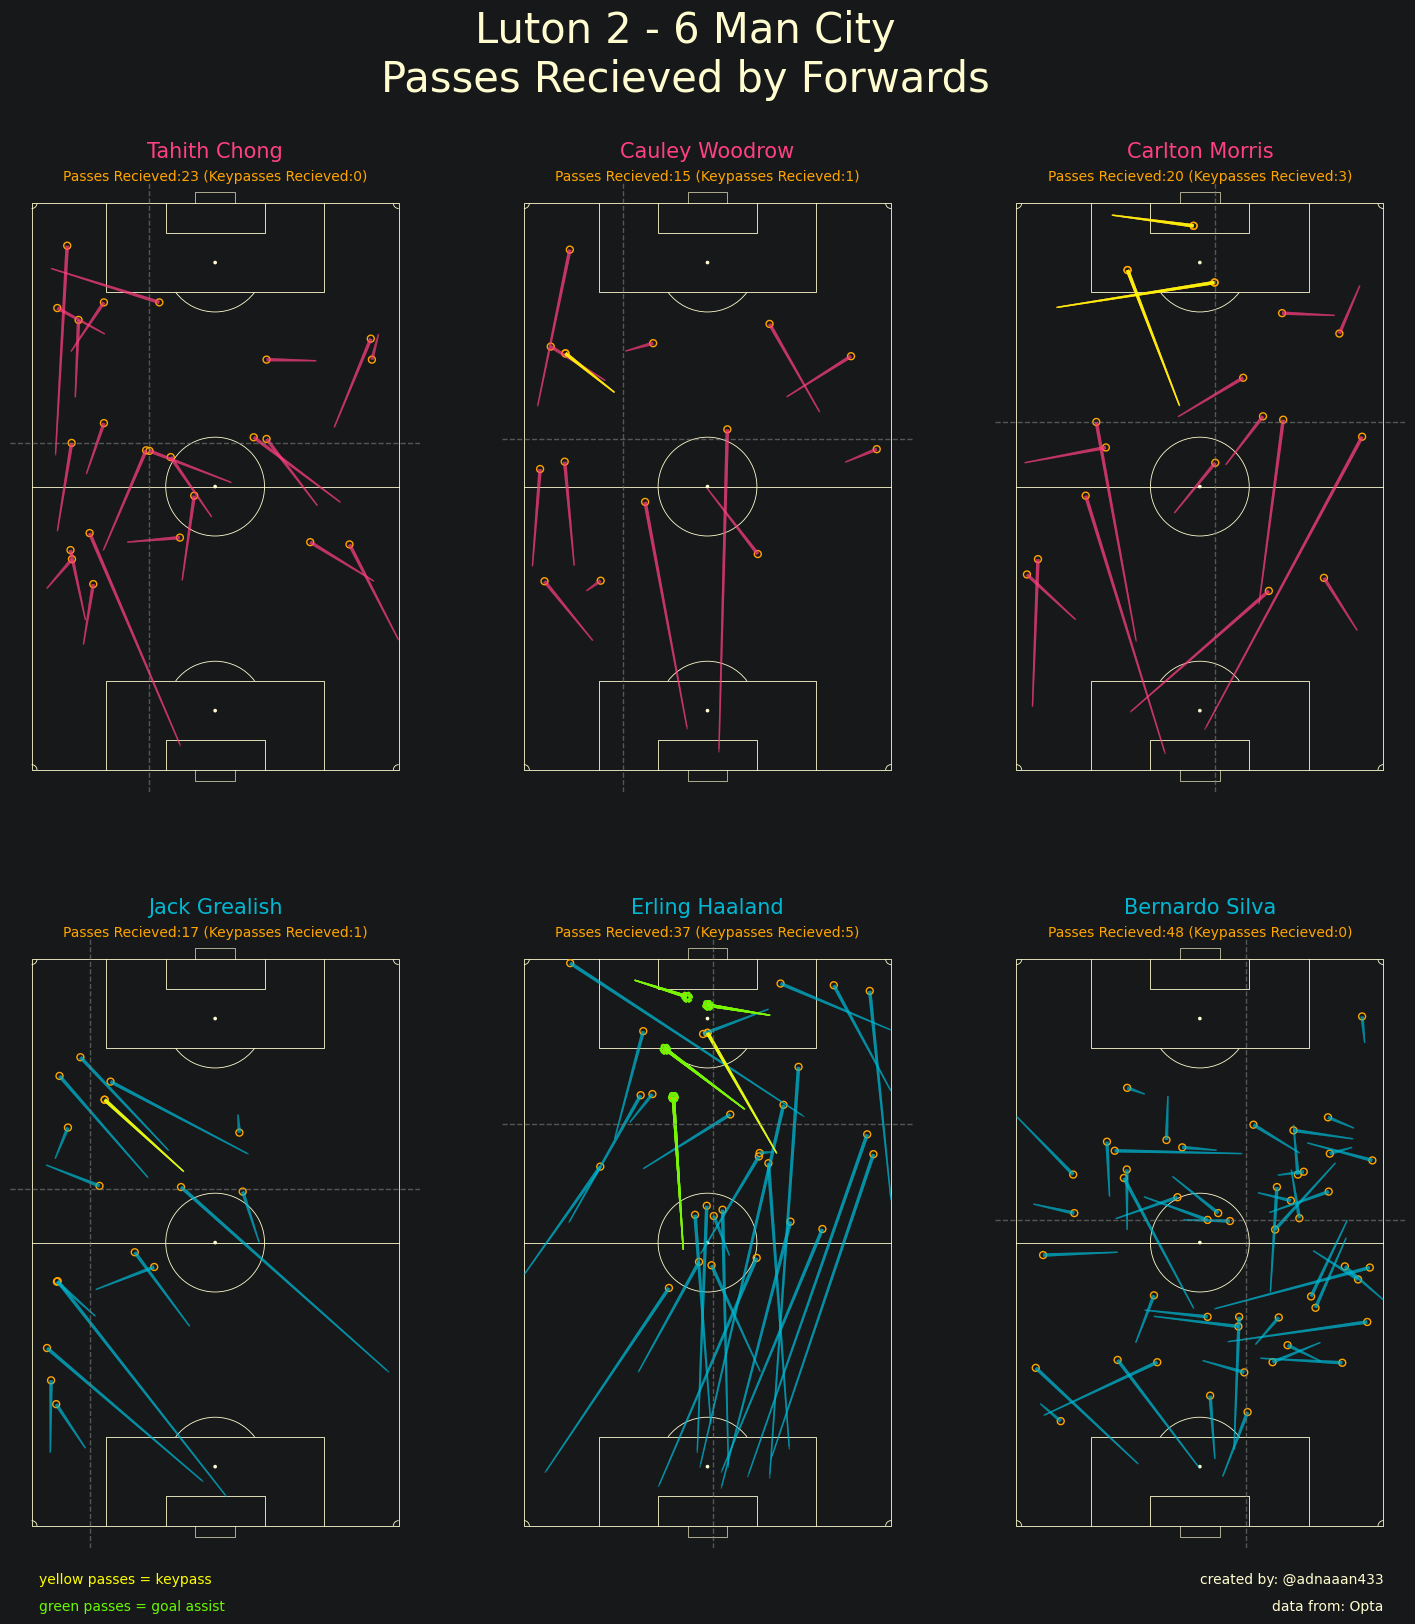

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(18, 18), facecolor=black)

def plot_passes_recieved(ax, name, teamName, col):
    pitch = VerticalPitch(pitch_type='uefa', goal_type='box', goal_alpha=.75, corner_arcs=True, pitch_color=black, line_color=white, linewidth=0.6)
    pitch.draw(ax=ax)
    filtered_rows = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['name'].shift(-1) == name)]
    keypass_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('KeyPass')]
    assist_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('IntentionalGoalAssist')]
    pr = len(filtered_rows)
    kpr = len(keypass_recieved_df)

    lc1 = pitch.lines(filtered_rows.y, filtered_rows.x, filtered_rows.endY, filtered_rows.endX, lw=2.5, transparent=True, comet=True,color=col, ax=ax, alpha=0.5)
    lc2 = pitch.lines(keypass_recieved_df.y, keypass_recieved_df.x, keypass_recieved_df.endY, keypass_recieved_df.endX, lw=2.5, transparent=True, comet=True,color='yellow', ax=ax, alpha=0.75)
    lc3 = pitch.lines(assist_recieved_df.y, assist_recieved_df.x, assist_recieved_df.endY, assist_recieved_df.endX, lw=2.5, transparent=True, comet=True,color=green, ax=ax, alpha=0.75)
    sc1 = pitch.scatter(filtered_rows.endY, filtered_rows.endX, s=25, edgecolor='orange', linewidth=1, color='None', ax=ax)
    sc2 = pitch.scatter(keypass_recieved_df.endY, keypass_recieved_df.endX, s=25, edgecolor='orange', linewidth=1, color='None', ax=ax)
    sc3 = pitch.scatter(assist_recieved_df.endY, assist_recieved_df.endX, s=50, edgecolor=green, linewidth=1, marker='football', c='None', ax=ax)

    avg_endX = filtered_rows['endX'].median()
    avg_endY = filtered_rows['endY'].median()
    ax.axvline(x=avg_endX, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    ax.axhline(y=avg_endY, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    ax.set_title(f"{name}", color=col, fontsize=15, y=1.025)
    ax.text(34, 110, f'Passes Recieved:{pr+kpr} (Keypasses Recieved:{kpr})', color='orange', fontsize=10, ha='center', va='center')

    return pitch

plot_passes_recieved(axs[0,0], "Tahith Chong", hteamName, hcol)
plot_passes_recieved(axs[0,1], "Cauley Woodrow", hteamName, hcol)
plot_passes_recieved(axs[0,2], "Carlton Morris", hteamName, hcol)
plot_passes_recieved(axs[1,0], "Jack Grealish", ateamName, acol)
plot_passes_recieved(axs[1,1], "Erling Haaland", ateamName, acol)
plot_passes_recieved(axs[1,2], "Bernardo Silva", ateamName, acol)

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nPasses Recieved by Forwards", fontsize=30, color=white, y=0.97)
plt.text(249,-10,'yellow passes = keypass', fontsize=10, color='yellow', va='center', ha='left')
plt.text(249,-15,'green passes = goal assist', fontsize=10, color=green, va='center', ha='left')
plt.text(0,-10,'created by: @adnaaan433', fontsize=10, color=white, va='center', ha='right')
plt.text(0,-15,'data from: Opta', fontsize=10, color=white, va='center', ha='right')

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Forwards_Pass_Recieving.png', bbox_inches='tight')
# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Forwards_Pass_Recieving.png')

# Player PassMap

---



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

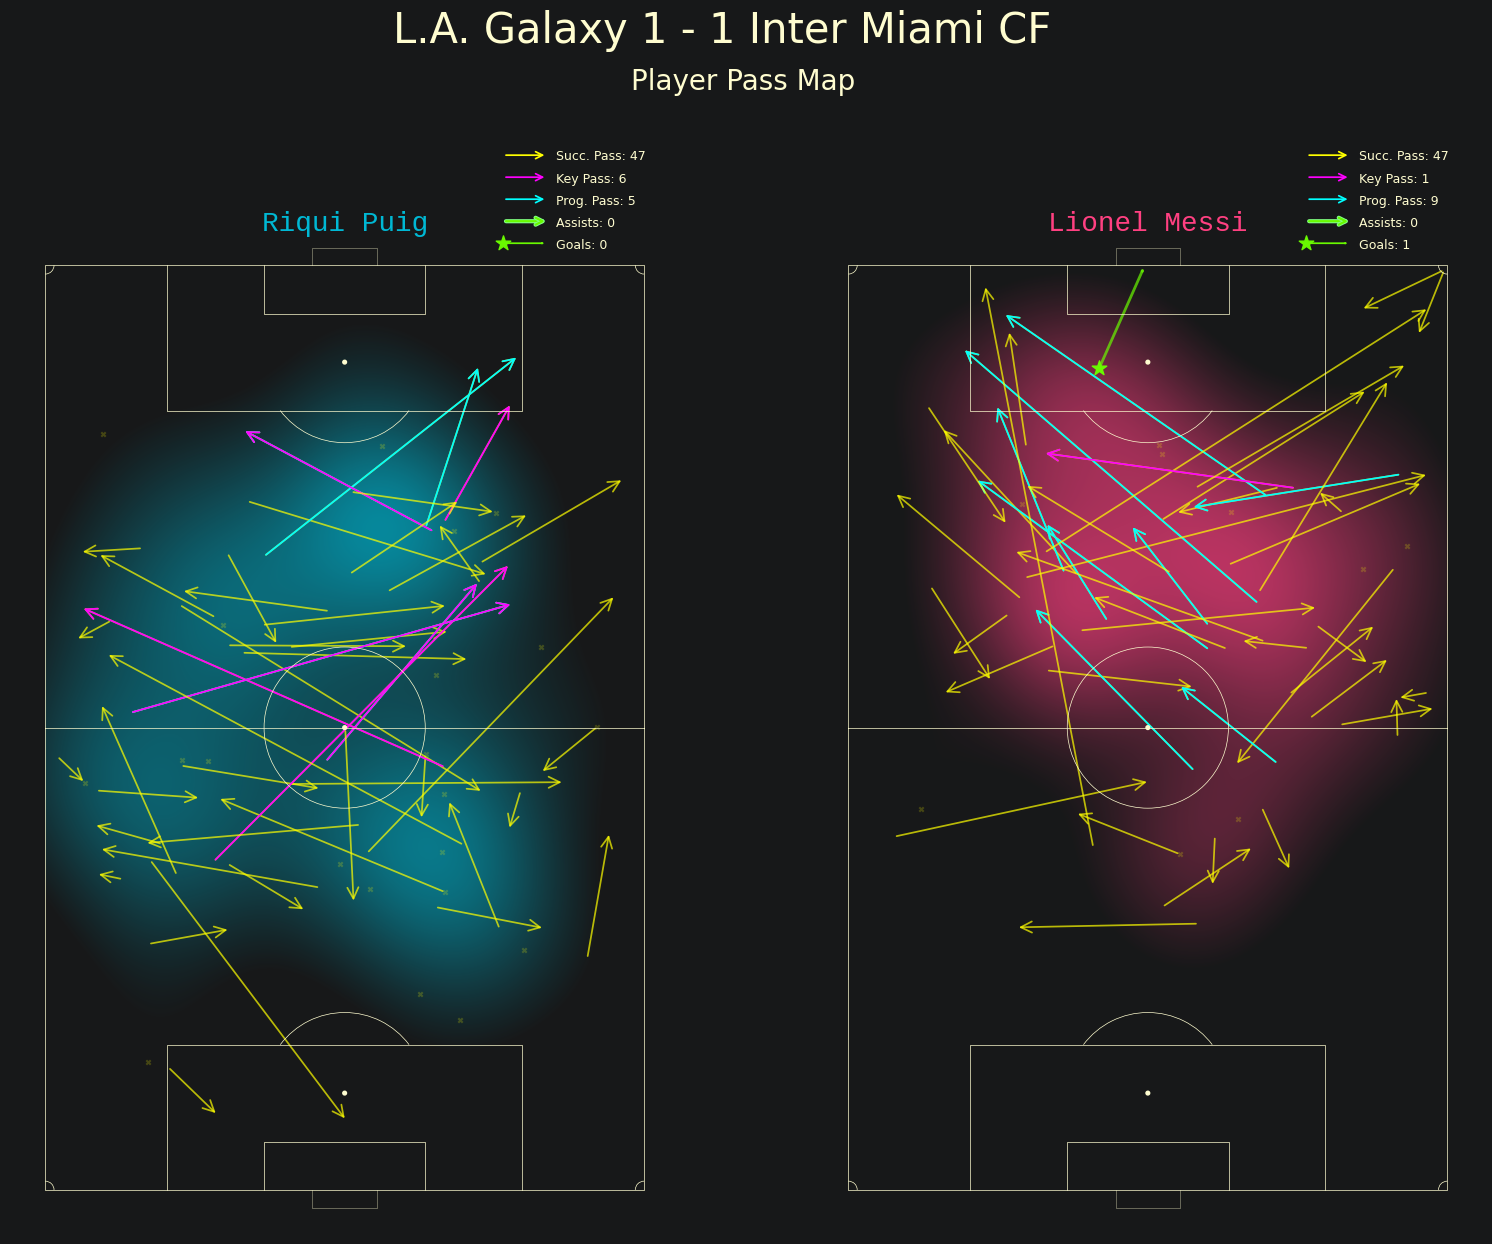

In [ ]:
# Create two separate figures and axes with a black background
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 19), facecolor=black)

# Create a function to draw the shot maps
def player_pass_map(ax, player_name, col):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=black, line_color=white, linewidth=0.5, line_zorder=2,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.set_ylim(-5, 120)

    yellow_arrow_count = 0
    green_arrow_count = 0
    cyan_arrow_count = 0
    magenta_arrow_count = 0
    goal_count = 0
    mask = (df['name'] == player_name)
    dfppm = df[mask]
    mask1 =  ((df['name'] == player_name) & ((df['type'] == 'Aerial') & (df['x'] <= 80) |
              (df['type'] == 'BallRecovery') |
              (df['type'] == 'BlockedPass') |
              (df['type'] == 'Challenge') |
              (df['type'] == 'Error') |
              (df['type'] == 'Foul') |
              (df['type'] == 'Interception') |
              (df['type'] == 'Tackle')))
    pda = df[mask1]

    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
                                                    [black, col], N=500)
    kde = pitch.kdeplot(dfppm.y, dfppm.x, ax=ax,
                          # fill using 100 levels so it looks smooth
                          fill=True, levels=5000,
                          # shade the lowest area so it looks smooth
                          # so even if there are no events it gets some color
                          thresh=0.1,
                          cut=4,  # extended the cut so it reaches the bottom edge
                          cmap=flamingo_cmap)
    x_blc = [0, 0, 68, 68]
    y_blc = [0, 105, 105, 0]
    ax.fill(x_blc, y_blc, black, alpha=0.3)

    da_scatter = pitch.scatter(pda.y, pda.x,
                               s=10, marker='x',
                               color='yellow', alpha=0.2, ax=ax)

    # Plot all the actions
    for index, row in dfppm.iterrows():
        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful'
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1.25, alpha=0.7)
            ax.add_patch(arrow)
            yellow_arrow_count += 1

        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful' and
            (
                (row['pro'] >= 9.144) or
                (row['x'] >= 42 and row['y'] >= 13.85 and row['y'] <= 54.15 and row['endX'] >= 88.54 and row['endY'] >= 13.85 and row['endY'] <= 54.15)
            )
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='cyan', linewidth=1.25)
            ax.add_patch(arrow)
            cyan_arrow_count += 1

        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful' and
            'KeyPass' in row['qualifiers']
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='magenta', linewidth=1.25)
            ax.add_patch(arrow)
            magenta_arrow_count += 1

        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful' and
            'IntentionalGoalAssist' in row['qualifiers']
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color=green, linewidth=1.25)
            arrow.set_path_effects([withStroke(linewidth=3, foreground='#80ff80'), Normal()])
            ax.add_patch(arrow)
            green_arrow_count += 1

        if (
            row['type'] == 'Goal'
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['goalMouthY'], 105), arrowstyle='->', mutation_scale=1, color=green, linewidth=2, alpha=0.7)
            ax.add_patch(arrow)
            ax.scatter(row['x'], row['y'], color=green, s=120, marker='*')
            goal_count += 1

    # Add custom text under the plot
    count_lines = [
        f"Succ. Pass: {yellow_arrow_count}",
        f"Key Pass: {magenta_arrow_count}",
        f"Prog. Pass: {cyan_arrow_count}",
        f"Assists: {green_arrow_count}",
        f"Goals: {goal_count}",
    ]

    # Add custom text lines for counts under the plot
    y_coordinate = 117
    for line in count_lines:
        ax.text(10, y_coordinate, line, fontsize=9, color=white, ha='left')
        y_coordinate -= 2.5

    Title = player_name
    font = FontProperties(family='Liberation Mono', style='normal', size=20)
    ax.text(34, 109, Title, fontproperties=font, color=col, ha='center')

    arrow = patches.FancyArrowPatch((16, 117.5), (11, 117.5), arrowstyle='->', mutation_scale=12.5, color='yellow', linewidth=1.25)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 115), (11, 115), arrowstyle='->', mutation_scale=12.5, color='magenta', linewidth=1.25)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 112.5), (11, 112.5), arrowstyle='->', mutation_scale=12.5, color='cyan', linewidth=1.25)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 110), (11, 110), arrowstyle='->', mutation_scale=12.5, color=green, linewidth=1.25)
    arrow.set_path_effects([withStroke(linewidth=3, foreground='#80ff80'), Normal()])
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 107.5), (11, 107.5), arrowstyle='->', mutation_scale=1, color=green, linewidth=1.25)
    ax.add_patch(arrow)
    ax.scatter(16, 107.5, color=green, s=120, marker='*')



player_pass_map(ax1, "Riqui Puig", hcol)
player_pass_map(ax2, "Lionel Messi", acol)

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}", fontsize=30, color=white, y=0.85)
plt.text(80, 125, "Player Pass Map",  fontsize=20, color=white, ha='center')

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}PlayerComparison.png', bbox_inches='tight')

# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}PlayerComparison.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

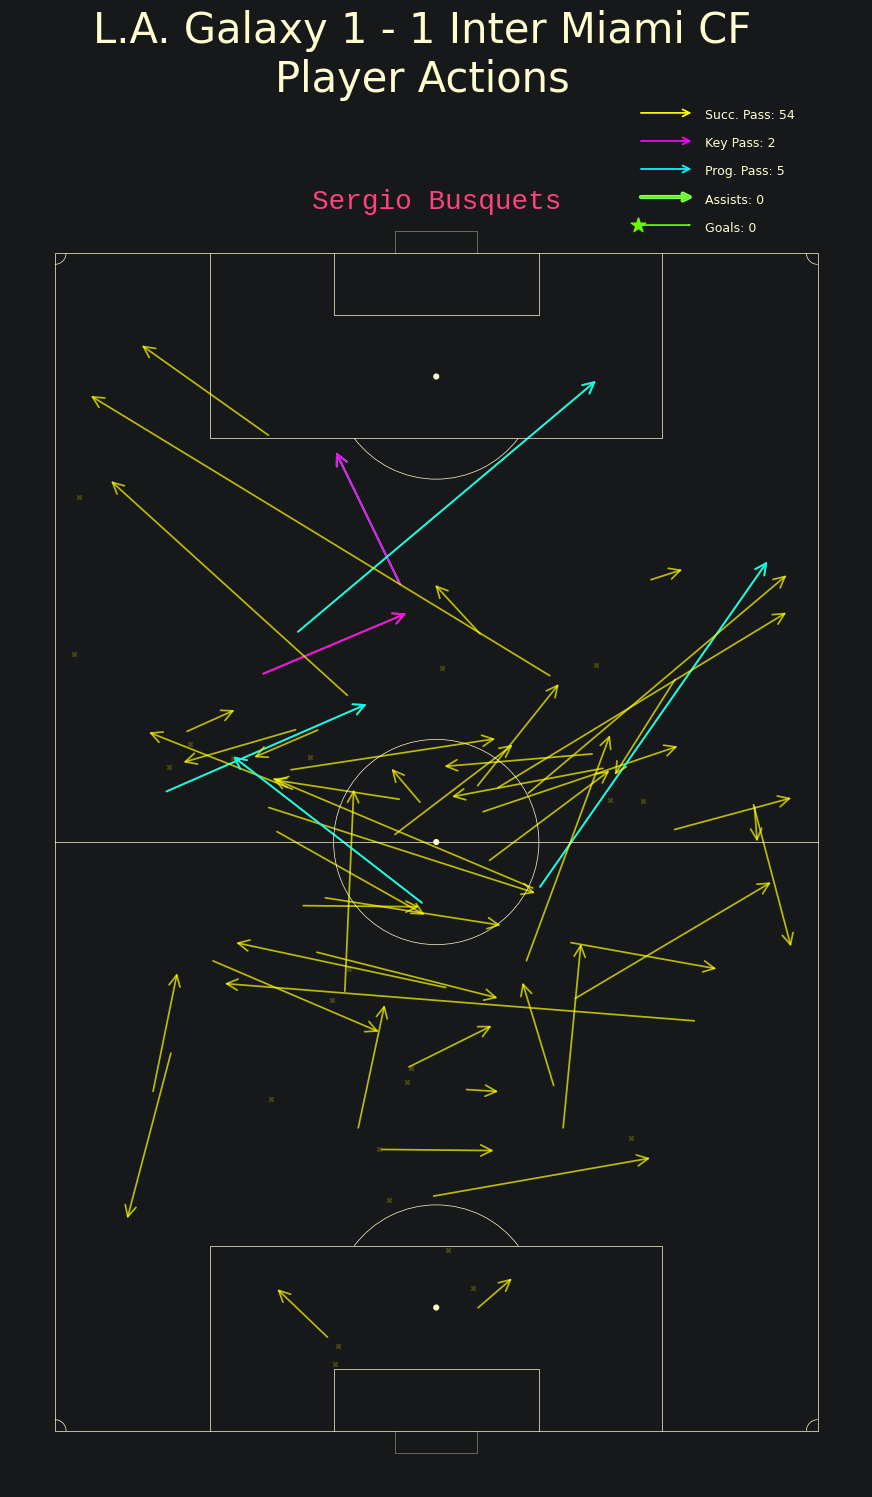

In [ ]:
# Create two separate figures and axes with a black background
fig, ax1 = plt.subplots(1, 1, figsize=(11, 19), facecolor=black)

# Create a function to draw the pass maps
def player_pass_map(ax, player_name, col):
    pitch = VerticalPitch(pitch_type='uefa', pitch_color=black, line_color=white, linewidth=0.5, line_zorder=2,
                          corner_arcs=True, goal_type='box', goal_alpha=.5)
    pitch.draw(ax=ax)
    ax.set_ylim(-5, 120)

    yellow_arrow_count = 0
    green_arrow_count = 0
    cyan_arrow_count = 0
    magenta_arrow_count = 0
    goal_count = 0
    mask = (df['name'] == player_name)
    dfppm = df[mask]
    mask1 =  ((df['name'] == player_name) & ((df['type'] == 'Aerial') & (df['x'] <= 80) |
              (df['type'] == 'BallRecovery') |
              (df['type'] == 'BlockedPass') |
              (df['type'] == 'Challenge') |
              (df['type'] == 'Error') |
              (df['type'] == 'Foul') |
              (df['type'] == 'Interception') |
              (df['type'] == 'Tackle')))
    pda = df[mask1]

    # flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
    #                                                 [black, col], N=500)
    # kde = pitch.kdeplot(dfppm.y, dfppm.x, ax=ax,
    #                       # fill using 100 levels so it looks smooth
    #                       fill=True, levels=5000,
    #                       # shade the lowest area so it looks smooth
    #                       # so even if there are no events it gets some color
    #                       thresh=0.1,
    #                       cut=4,  # extended the cut so it reaches the bottom edge
    #                       cmap=flamingo_cmap)
    x_blc = [0, 0, 68, 68]
    y_blc = [0, 105, 105, 0]
    ax.fill(x_blc, y_blc, black, alpha=0.3)

    da_scatter = pitch.scatter(pda.y, pda.x,
                               s=10, marker='x',
                               color='yellow', alpha=0.2, ax=ax)

    # Plot all the actions
    for index, row in dfppm.iterrows():
        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful'
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='yellow', linewidth=1.25, alpha=0.7)
            ax.add_patch(arrow)
            yellow_arrow_count += 1

        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful' and
            (
                (row['pro'] >= 9.144) or
                (row['x'] >= 42 and row['y'] >= 13.85 and row['y'] <= 54.15 and row['endX'] >= 88.54 and row['endY'] >= 13.85 and row['endY'] <= 54.15)
            )
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='cyan', linewidth=1.25)
            ax.add_patch(arrow)
            cyan_arrow_count += 1

        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful' and
            'KeyPass' in row['qualifiers']
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color='magenta', linewidth=1.25)
            ax.add_patch(arrow)
            magenta_arrow_count += 1

        if (
            row['type'] == 'Pass' and
            row['outcomeType'] == 'Successful' and
            'IntentionalGoalAssist' in row['qualifiers']
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', mutation_scale=20, color=green, linewidth=1.25)
            arrow.set_path_effects([withStroke(linewidth=3, foreground='#80ff80'), Normal()])
            ax.add_patch(arrow)
            green_arrow_count += 1

        if (
            row['type'] == 'Goal'
        ):
            arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['goalMouthY'], 105), arrowstyle='->', mutation_scale=1, color=green, linewidth=2, alpha=0.7)
            ax.add_patch(arrow)
            ax.scatter(row['x'], row['y'], color=green, s=120, marker='*')
            goal_count += 1

    # Add custom text under the plot
    count_lines = [
        f"Succ. Pass: {yellow_arrow_count}",
        f"Key Pass: {magenta_arrow_count}",
        f"Prog. Pass: {cyan_arrow_count}",
        f"Assists: {green_arrow_count}",
        f"Goals: {goal_count}",
    ]

    # Add custom text lines for counts under the plot
    y_coordinate = 117
    for line in count_lines:
        ax.text(10, y_coordinate, line, fontsize=9, color=white, ha='left')
        y_coordinate -= 2.5

    Title = player_name
    font = FontProperties(family='Liberation Mono', style='normal', size=20)
    ax.text(34, 109, Title, fontproperties=font, color=col, ha='center')

    arrow = patches.FancyArrowPatch((16, 117.5), (11, 117.5), arrowstyle='->', mutation_scale=12.5, color='yellow', linewidth=1.25)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 115), (11, 115), arrowstyle='->', mutation_scale=12.5, color='magenta', linewidth=1.25)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 112.5), (11, 112.5), arrowstyle='->', mutation_scale=12.5, color='cyan', linewidth=1.25)
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 110), (11, 110), arrowstyle='->', mutation_scale=12.5, color=green, linewidth=1.25)
    arrow.set_path_effects([withStroke(linewidth=3, foreground='#80ff80'), Normal()])
    ax.add_patch(arrow)
    arrow = patches.FancyArrowPatch((16, 107.5), (11, 107.5), arrowstyle='->', mutation_scale=1, color=green, linewidth=1.25)
    ax.add_patch(arrow)
    ax.scatter(16, 107.5, color=green, s=120, marker='*')



player_pass_map(ax1, "Sergio Busquets", acol)

plt.suptitle(f"{hteamName} {hgoal_count} - {agoal_count} {ateamName}\nPlayer Actions", va='center', ha='center', fontsize=30, color=white, y=0.88)

# Save the plot as an image file (e.g., PNG)
plt.savefig(f'{file_header}Sergio Busquets.png', bbox_inches='tight')

# Use the files module to download the saved image
from google.colab import files
files.download(f'{file_header}Sergio Busquets.png')

# Clear the files

---



In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Iterate through the files and delete them
for root, dirs, files in os.walk(current_directory):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

Deleted: /content/lutmncCrosses.png
Deleted: /content/lutmncDefensive_Block.png
Deleted: /content/lutmncForwards_Pass_Recieving.png
Deleted: /content/lutmncPasses_into_Danger_zone.png
Deleted: /content/lutmncProgressive_Passes_Cluster.png
Deleted: /content/EventData.csv
Deleted: /content/lutmncChances_creating_zone.png
Deleted: /content/PlayerData.csv
Deleted: /content/lutmnc.csv
Deleted: /content/Luton 2-6 Manchester City - FA Cup 2023_2024 Live.html
Deleted: /content/lutmncPass_Network.png
Deleted: /content/lutmncPass_Ending_Zone.png
Deleted: /content/lutmncPasses_from_Danger_zone.png
Deleted: /content/.config/.last_update_check.json
Deleted: /content/.config/active_config
Deleted: /content/.config/gce
Deleted: /content/.config/config_sentinel
Deleted: /content/.config/.last_opt_in_prompt.yaml
Deleted: /content/.config/default_configs.db
Deleted: /content/.config/.last_survey_prompt.yaml
Deleted: /content/.config/configurations/config_default
Deleted: /content/.config/logs/2024.02.27